# Testing the functions in torchgp.parameterizations.natural

In [1]:
%matplotlib notebook

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchgp.symbolic import *
from torchgp.transforms import *
from torchgp.reparameterization import *
from torchgp.test_tools import *
from torchgp.kernels import *
from torchgp.parameterizations.natural import *
from torchgp.factorizations.randomized import *
from torchgp.natural_gradient import *
from torchgp.natural_gradient.optimizer import PatchAdam
import math
import networkx as nx
from matplotlib.pyplot import *
from itertools import chain
torch.set_default_dtype(torch.float32)

## Example 1a:

1. Fully observed
2. Gaussian likelihood
3. MC evaluation of likelihood, aka reparameterization gradients
4. 1D signal

In [121]:
#generate the data
x, yc, y = make_fake_herfd_fully_observed(10, 200, mean_snr=1.0)

<IPython.core.display.Javascript object>


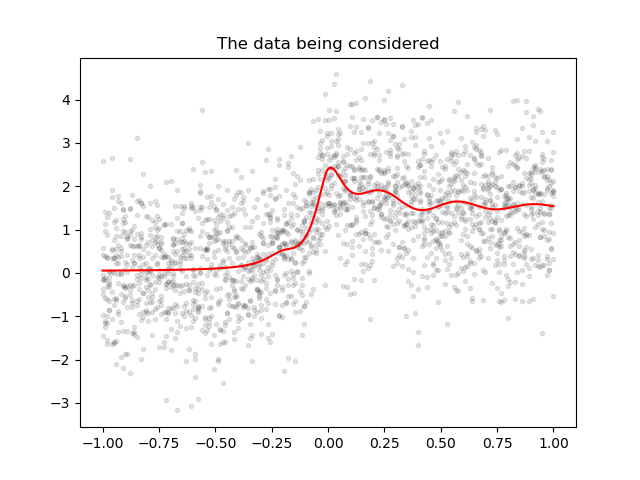

Text(0.5, 1.0, 'The data being considered')

In [105]:
figure()
plot(x,yc,'k.',alpha=0.1)
plot(x[:200],y,'r')
title('The data being considered')

In [31]:
class VFE_1D(torch.nn.Module):
    def __init__(self, U, Ntotal, Nmc = 10, std_lik_init = 5.0, lenscale_init = 0.1, dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        #define the input parameters
        #posterior mean vector
        m0 = MeanSymbol('m0')
        t = Vector('t')
        #posterior variance vector parameter
        T = Matrix('T')
        #axes that kernels are evaluated on
        u = Vector('u')
        f = Vector('f')
        #Kernels
        #these are the symbols that go into the graph
        K = Kernel('K')
        #observations, arranged Nx1
        y = Vector('y')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        Nmc = Constant(Nmc)
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl(K, u, m0, T, t, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K, u, f, m0, T, t, jitter)
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K, f) - var_subspace_diag(K, u, f, jitter) + var_posterior_diag(K, u, f, T, jitter)
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        
        ### Gaussian Likelihood in f-space ###
#         ve_loss = analytic_gaussian_likelihood(y, mf, varf, std_lik, Ntotal)
        ϵ = StdNormalSample(mf,Nmc)
        z = Sqrt(varf)*ϵ + mf
        ve_loss = gaussian_likelihood(y, z, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #symbolic functions needed for natural gradient:
        xi_to_source = natural_to_source(t,T,jitter)
        graph = expr2graph(Label(String("xi_to_source"), xi_to_source))
        self._xi_to_source = graph2ast(graph, compiled=True, debug=False)
        source_mean = Vector('source_mean')
        source_var = Matrix('source_var')
        source_to_xi = source_to_natural(source_mean, source_var, jitter)
        graph = expr2graph(Label(String("source_to_xi"), source_to_xi))
        self._source_to_xi = graph2ast(graph, compiled=True, debug=False)
        
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u': torch.nn.Parameter(torch.linspace(-1,1,U,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False)
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]], dtype=self.dtype)),
                'm0': ConstantMean(torch.tensor(0., dtype=self.dtype), dtype=self.dtype),
                })
            #modules containing variational parameters go here:
            priorL = (self.stored_modules['K'](self.hyper_params['u'],self.hyper_params['u']) + 
                  torch.eye(U)*1e-4).cholesky()
            priorT = 0.5*torch.triangular_solve(torch.triangular_solve(torch.eye(U),priorL,upper=False).solution,priorL,upper=False,transpose=True).solution
            self.variational_gaussian = MVNGaussianNatural(U, dtype=self.dtype)
#             self.variational_gaussian.custom_T_init(priorT)
    def kl_loss(self):
        t, T = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'T': T,
            't': t
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, x):
        t, T = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'f': x,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'T': T,
            't': t
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, x):
        t, T = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'f': x,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'T': T,
            't': t
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self, x):
        t, T = self.variational_gaussian.unpack()
        leaves = {
            'f': x,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'T': T,
            't': t
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self, x):
        t, T = self.variational_gaussian.unpack()
        leaves = {
            'f': x,
            **self.hyper_params,
            **self.stored_modules,
            'std_lik': self._makepos(self.hyper_params['std_lik']),
            'T': T,
            't': t
        }
        result = self._var_pred(**leaves)
        return result.var_pred
    def xi_to_source(self, xi):
        t, T = self.variational_gaussian.unpack(xi_packed=xi)
        leaves = {
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'T': T,
                't': t
            }
        m,S = self._xi_to_source(**leaves).xi_to_source
        return [m,S]
    def source_to_xi(self, m, S):
        leaves = {
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'source_mean': m,
                'source_var': S
            }
        xi_unpacked = self._source_to_xi(**leaves).source_to_xi
        xi = self.variational_gaussian.pack(xi_unpacked)
        if torch.is_tensor(xi):
            return [xi]
        else:
            return list(xi)
        

## Test the KL first

In [123]:
m = VFE_1D(30,200*10);

Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/13d29a5f0115999d.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/91e0d7c89b5cf488.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/9607c224a612fad4.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/69b5226022d8696a.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/273628fd6b11ae5d.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/d9c8c7da9fc587b3.py
Module path:  /Users/fdfuller/SLAC National Ac

In [151]:
class FixedConstrainedNaturalGradient(Optimizer):
    """
    This is a special optimizer that assumes we are using natural parameterization. It therefore also assumes that
    xi = [t, T]. We require that you additionally supply methods to pack and unpack T the parameter vector.

    The optimizer is constrained in the sense that we will check that the update applied to the precision matrix is
    positive definite and this is checked by taking the symeig of the unpacked update. We then either truncate or inflate
    the eigenvalues of the update so that it becomes positive semi definite.
    """
    def __init__(self, params, lr=1.0, natural_parameterization=True):
        if lr<0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not natural_parameterization:
            raise ValueError(f"must use natural parameterization")
        defaults = {'lr': lr, 'natural_parameterization': natural_parameterization}
        super().__init__(params, defaults)
        if len(self.param_groups) != 1:
            raise ValueError("Natural Gradient doesn't support per-parameter options "
                             "(parameter groups)")
        self.add_param_group = blank_fun
        self._params = self.param_groups[0]['params']
    def step(self, xi_to_source, source_to_xi, pack, unpack, closure = None):
        """

        :param closure: a callable to compute the loss
        :param xi_to_source: a callable to convert packed model parameterization to
                unpacked source parameterization (mean, variance). Expected to take a single list-valued argument and
                return a list of [mean, variance]
        :param source_to_xi: a callable to convert unpacked source parameterization to packed model parameterization
                Expected to accept a list of inputs [mean, variance] and return a list of parameters corresponding to
                how xi is stored in the model
        :param pack: a callable to convert unpacked xi to packed xi
        :param unpack: a callable to convert packed xi to unpacked xi

        performs a step along the natural gradient on the MVN distribution this optimizer was initialized for.
        """
        lr = self.param_groups[0]['lr']
        loss = None
        if closure is not None:
            loss = closure()
            dL_dxi = vjp(loss,self._params)
        else:
            dL_dxi = [p.grad.data for p in self._params]
        xi = self._params #always a list, even when containing 1 element
        with torch.no_grad():
            expectation = [x.clone().detach().requires_grad_(True) for x in source2expectation(*xi_to_source(xi))]
            natural = [x.clone().detach().requires_grad_(True) for x in source2natural(*xi_to_source(xi))]
        xi_from_expectation = source_to_xi(*expectation2source(*expectation))
        xi_from_natural = source_to_xi(*natural2source(*natural))
        nat_grad = jvp(xi_from_natural, natural, vjp(xi_from_expectation, expectation, dL_dxi))
        with torch.no_grad():
            candidates = [p.data -lr*g for p,g in zip(self._params, nat_grad)]
            t_new, T_new = unpack(candidates)
            Emin = torch.symeig(T_new).eigenvalues.min()
            attempts = 0
            while Emin<0. and attempts<8:
                attempts += 1
                lr = lr * (1/2)
                candidates = [p.data -lr*g for p,g in zip(self._params, nat_grad)]
                t_new, T_new = unpack(candidates)
                Emin = torch.symeig(T_new).eigenvalues.min()
            if attempts>0:
                print(f'lr reduced over {attempts} attempts to {lr}')
            repacked = pack([t_new, T_new])
            for p,c in zip(self._params,repacked):
                p.data[...] = c.data
        return loss

In [152]:
m = VFE_1D(80,200*1000);
# m.hyper_params['u'].requires_grad = False
# m.stored_modules['K']._lengthscale_storage.requires_grad = False
# m.stored_modules['K']._amplitude_storage.requires_grad = False
# m.stored_modules['m0'].value.requires_grad = False
# m.cuda()
# optimizer = NaturalGradient(m.variational_gaussian.parameters(), lr=1)
optimizer = FixedConstrainedNaturalGradient(m.variational_gaussian.parameters(), lr=1)
schedule = LogSpaceScheduler(optimizer, -1, 0, 10)
# bigbatcher = BigBatchScheduler(1000,5000,10,30)


epochs = 150

for i in range(epochs):
    optimizer.zero_grad()
    loss = m.kl_loss()
    loss.backward()
#     schedule.step()
    optimizer.step(m.xi_to_source, m.source_to_xi, m.variational_gaussian.pack, m.variational_gaussian.unpack)
    print(f"i: loss = {loss.item()}, stepsize = {optimizer.param_groups[0]['lr']}")
        

Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/13d29a5f0115999d.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/91e0d7c89b5cf488.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/9607c224a612fad4.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/0376d3e8d44257ea.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/7b1d1751c2251c9b.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/d9c8c7da9fc587b3.py
Module path:  /Users/fdfuller/SLAC National Ac

In [45]:
m = VFE_1D(100,200*10);
# m.hyper_params['u'].requires_grad = False
# m.stored_modules['K']._lengthscale_storage.requires_grad = False
# m.stored_modules['K']._amplitude_storage.requires_grad = False
# m.stored_modules['m0'].value.requires_grad = False
# m.cuda()
hyper_optimizer = PatchAdam(chain(m.hyper_params.parameters(), m.stored_modules.parameters()),lr=1e-3)
optimizer = NaturalGradient(m.variational_gaussian.parameters(), lr=1)
schedule = LogSpaceScheduler(optimizer, -5, -1.5, 10)
bigbatcher = BigBatchScheduler(500,2000,10,30)


initial = 50
epochs = 5000
final = -50
# scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(torch.from_numpy(x.astype('float32')), torch.from_numpy(yc.astype('float32')))
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_modules.K._lengthscale_storage': m._makepos,
                          'stored_modules.K._amplitude_storage': m._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})
c = 0
while c < epochs:
    bsize = bigbatcher.step()
    print(bsize)
    d = DataLoader(dataset=data, shuffle=True, batch_size=int(bsize))
    for (xb,yb) in d:
#         xbc, ybc = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        hyper_optimizer.zero_grad()
        loss = m.loss(yb, xb)
        loss.backward()
        if c == initial:
            schedule.reset()
        schedule.step()
        optimizer.step(m.xi_to_source, m.source_to_xi)
        if c < initial or c > epochs + final:
            hyper_optimizer.step(null_step=True)
        else:
            hyper_optimizer.step(null_step=False)
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    print(Logger.report("epoch {:d}: ".format(c)))
    c += 1

Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/bf6b7b2df66d9b04.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/24095a543d9b8727.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/11e54b4f4278d116.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/91c6b159e165d717.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/88d227685a5f89a8.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/0f4ed927b2d91f2a.py
Module path:  /Users/fdfuller/SLAC National Ac

epoch 42: hyper_params.std_lik: 5, stored_modules.K._lengthscale_storage: 0.0953102, stored_modules.K._amplitude_storage: 0.693147, loss: 5120.48, step_size: 0.0316228, 
666
epoch 43: hyper_params.std_lik: 5, stored_modules.K._lengthscale_storage: 0.0953102, stored_modules.K._amplitude_storage: 0.693147, loss: 5104.44, step_size: 0.0316228, 
666
epoch 44: hyper_params.std_lik: 5, stored_modules.K._lengthscale_storage: 0.0953102, stored_modules.K._amplitude_storage: 0.693147, loss: 5105.81, step_size: 0.0316228, 
666
epoch 45: hyper_params.std_lik: 5, stored_modules.K._lengthscale_storage: 0.0953102, stored_modules.K._amplitude_storage: 0.693147, loss: 5089.56, step_size: 0.0316228, 
666
epoch 46: hyper_params.std_lik: 5, stored_modules.K._lengthscale_storage: 0.0953102, stored_modules.K._amplitude_storage: 0.693147, loss: 5092.66, step_size: 0.0316228, 
666
epoch 47: hyper_params.std_lik: 5, stored_modules.K._lengthscale_storage: 0.0953102, stored_modules.K._amplitude_storage: 0.693147

epoch 88: hyper_params.std_lik: 4.87217, stored_modules.K._lengthscale_storage: 0.100125, stored_modules.K._amplitude_storage: 0.682109, loss: 5069.9, step_size: 0.0316228, 
833
epoch 89: hyper_params.std_lik: 4.86913, stored_modules.K._lengthscale_storage: 0.100224, stored_modules.K._amplitude_storage: 0.681763, loss: 5064.51, step_size: 0.0316228, 
1000
epoch 90: hyper_params.std_lik: 4.8671, stored_modules.K._lengthscale_storage: 0.10029, stored_modules.K._amplitude_storage: 0.681527, loss: 5070.54, step_size: 0.0316228, 
1000
epoch 91: hyper_params.std_lik: 4.86507, stored_modules.K._lengthscale_storage: 0.100357, stored_modules.K._amplitude_storage: 0.681287, loss: 5070.04, step_size: 0.0316228, 
1000
epoch 92: hyper_params.std_lik: 4.86304, stored_modules.K._lengthscale_storage: 0.100423, stored_modules.K._amplitude_storage: 0.681044, loss: 5065.62, step_size: 0.0316228, 
1000
epoch 93: hyper_params.std_lik: 4.86101, stored_modules.K._lengthscale_storage: 0.10049, stored_modules.

epoch 136: hyper_params.std_lik: 4.77337, stored_modules.K._lengthscale_storage: 0.103397, stored_modules.K._amplitude_storage: 0.666299, loss: 5030.31, step_size: 0.0316228, 
1166
epoch 137: hyper_params.std_lik: 4.77133, stored_modules.K._lengthscale_storage: 0.103465, stored_modules.K._amplitude_storage: 0.665863, loss: 5026.66, step_size: 0.0316228, 
1166
epoch 138: hyper_params.std_lik: 4.76928, stored_modules.K._lengthscale_storage: 0.103533, stored_modules.K._amplitude_storage: 0.665421, loss: 5030.11, step_size: 0.0316228, 
1166
epoch 139: hyper_params.std_lik: 4.76724, stored_modules.K._lengthscale_storage: 0.103602, stored_modules.K._amplitude_storage: 0.664975, loss: 5030.77, step_size: 0.0316228, 
1166
epoch 140: hyper_params.std_lik: 4.76519, stored_modules.K._lengthscale_storage: 0.10367, stored_modules.K._amplitude_storage: 0.664523, loss: 5028.37, step_size: 0.0316228, 
1166
epoch 141: hyper_params.std_lik: 4.76314, stored_modules.K._lengthscale_storage: 0.103738, store

epoch 183: hyper_params.std_lik: 4.67687, stored_modules.K._lengthscale_storage: 0.106628, stored_modules.K._amplitude_storage: 0.641599, loss: 4992.67, step_size: 0.0316228, 
1500
epoch 184: hyper_params.std_lik: 4.67481, stored_modules.K._lengthscale_storage: 0.106697, stored_modules.K._amplitude_storage: 0.640999, loss: 4988.14, step_size: 0.0316228, 
1500
epoch 185: hyper_params.std_lik: 4.67275, stored_modules.K._lengthscale_storage: 0.106766, stored_modules.K._amplitude_storage: 0.640394, loss: 4985.61, step_size: 0.0316228, 
1500
epoch 186: hyper_params.std_lik: 4.67069, stored_modules.K._lengthscale_storage: 0.106836, stored_modules.K._amplitude_storage: 0.639785, loss: 4987.11, step_size: 0.0316228, 
1500
epoch 187: hyper_params.std_lik: 4.66862, stored_modules.K._lengthscale_storage: 0.106906, stored_modules.K._amplitude_storage: 0.639171, loss: 4987.61, step_size: 0.0316228, 
1500
epoch 188: hyper_params.std_lik: 4.66656, stored_modules.K._lengthscale_storage: 0.106976, stor

epoch 231: hyper_params.std_lik: 4.57757, stored_modules.K._lengthscale_storage: 0.109989, stored_modules.K._amplitude_storage: 0.609628, loss: 4946.65, step_size: 0.0316228, 
1666
epoch 232: hyper_params.std_lik: 4.5755, stored_modules.K._lengthscale_storage: 0.11006, stored_modules.K._amplitude_storage: 0.608882, loss: 4946.99, step_size: 0.0316228, 
1666
epoch 233: hyper_params.std_lik: 4.57342, stored_modules.K._lengthscale_storage: 0.110132, stored_modules.K._amplitude_storage: 0.608135, loss: 4948.09, step_size: 0.0316228, 
1666
epoch 234: hyper_params.std_lik: 4.57134, stored_modules.K._lengthscale_storage: 0.110203, stored_modules.K._amplitude_storage: 0.60739, loss: 4946.9, step_size: 0.0316228, 
1666
epoch 235: hyper_params.std_lik: 4.56927, stored_modules.K._lengthscale_storage: 0.110274, stored_modules.K._amplitude_storage: 0.606646, loss: 4948.65, step_size: 0.0316228, 
1666
epoch 236: hyper_params.std_lik: 4.56719, stored_modules.K._lengthscale_storage: 0.110345, stored_m

epoch 278: hyper_params.std_lik: 4.48911, stored_modules.K._lengthscale_storage: 0.112988, stored_modules.K._amplitude_storage: 0.577771, loss: 4910.84, step_size: 0.0316228, 
2000
epoch 279: hyper_params.std_lik: 4.48807, stored_modules.K._lengthscale_storage: 0.113024, stored_modules.K._amplitude_storage: 0.577398, loss: 4910.09, step_size: 0.0316228, 
2000
epoch 280: hyper_params.std_lik: 4.48702, stored_modules.K._lengthscale_storage: 0.11306, stored_modules.K._amplitude_storage: 0.577024, loss: 4909.83, step_size: 0.0316228, 
2000
epoch 281: hyper_params.std_lik: 4.48598, stored_modules.K._lengthscale_storage: 0.113096, stored_modules.K._amplitude_storage: 0.57665, loss: 4909.54, step_size: 0.0316228, 
2000
epoch 282: hyper_params.std_lik: 4.48494, stored_modules.K._lengthscale_storage: 0.113132, stored_modules.K._amplitude_storage: 0.576276, loss: 4909.28, step_size: 0.0316228, 
2000
epoch 283: hyper_params.std_lik: 4.48389, stored_modules.K._lengthscale_storage: 0.113168, stored

epoch 325: hyper_params.std_lik: 4.43997, stored_modules.K._lengthscale_storage: 0.114686, stored_modules.K._amplitude_storage: 0.559958, loss: 4889.51, step_size: 0.0316228, 
2000
epoch 326: hyper_params.std_lik: 4.43892, stored_modules.K._lengthscale_storage: 0.114722, stored_modules.K._amplitude_storage: 0.559577, loss: 4889.29, step_size: 0.0316228, 
2000
epoch 327: hyper_params.std_lik: 4.43787, stored_modules.K._lengthscale_storage: 0.114759, stored_modules.K._amplitude_storage: 0.559195, loss: 4889.02, step_size: 0.0316228, 
2000
epoch 328: hyper_params.std_lik: 4.43682, stored_modules.K._lengthscale_storage: 0.114795, stored_modules.K._amplitude_storage: 0.558813, loss: 4888.32, step_size: 0.0316228, 
2000
epoch 329: hyper_params.std_lik: 4.43578, stored_modules.K._lengthscale_storage: 0.114832, stored_modules.K._amplitude_storage: 0.558431, loss: 4888.25, step_size: 0.0316228, 
2000
epoch 330: hyper_params.std_lik: 4.43473, stored_modules.K._lengthscale_storage: 0.114868, stor

epoch 373: hyper_params.std_lik: 4.38962, stored_modules.K._lengthscale_storage: 0.116456, stored_modules.K._amplitude_storage: 0.541651, loss: 4868.06, step_size: 0.0316228, 
2000
epoch 374: hyper_params.std_lik: 4.38857, stored_modules.K._lengthscale_storage: 0.116493, stored_modules.K._amplitude_storage: 0.541271, loss: 4867.21, step_size: 0.0316228, 
2000
epoch 375: hyper_params.std_lik: 4.38752, stored_modules.K._lengthscale_storage: 0.116531, stored_modules.K._amplitude_storage: 0.540891, loss: 4866.65, step_size: 0.0316228, 
2000
epoch 376: hyper_params.std_lik: 4.38647, stored_modules.K._lengthscale_storage: 0.116568, stored_modules.K._amplitude_storage: 0.540512, loss: 4865.89, step_size: 0.0316228, 
2000
epoch 377: hyper_params.std_lik: 4.38542, stored_modules.K._lengthscale_storage: 0.116605, stored_modules.K._amplitude_storage: 0.540132, loss: 4865.57, step_size: 0.0316228, 
2000
epoch 378: hyper_params.std_lik: 4.38437, stored_modules.K._lengthscale_storage: 0.116643, stor

epoch 421: hyper_params.std_lik: 4.33911, stored_modules.K._lengthscale_storage: 0.118252, stored_modules.K._amplitude_storage: 0.523661, loss: 4845.52, step_size: 0.0316228, 
2000
epoch 422: hyper_params.std_lik: 4.33806, stored_modules.K._lengthscale_storage: 0.11829, stored_modules.K._amplitude_storage: 0.523291, loss: 4844.71, step_size: 0.0316228, 
2000
epoch 423: hyper_params.std_lik: 4.33701, stored_modules.K._lengthscale_storage: 0.118328, stored_modules.K._amplitude_storage: 0.522922, loss: 4845.03, step_size: 0.0316228, 
2000
epoch 424: hyper_params.std_lik: 4.33595, stored_modules.K._lengthscale_storage: 0.118366, stored_modules.K._amplitude_storage: 0.522552, loss: 4844.5, step_size: 0.0316228, 
2000
epoch 425: hyper_params.std_lik: 4.3349, stored_modules.K._lengthscale_storage: 0.118404, stored_modules.K._amplitude_storage: 0.522183, loss: 4844.02, step_size: 0.0316228, 
2000
epoch 426: hyper_params.std_lik: 4.33385, stored_modules.K._lengthscale_storage: 0.118442, stored_

epoch 467: hyper_params.std_lik: 4.29057, stored_modules.K._lengthscale_storage: 0.120013, stored_modules.K._amplitude_storage: 0.506858, loss: 4823.98, step_size: 0.0316228, 
2000
epoch 468: hyper_params.std_lik: 4.28952, stored_modules.K._lengthscale_storage: 0.120052, stored_modules.K._amplitude_storage: 0.5065, loss: 4823.07, step_size: 0.0316228, 
2000
epoch 469: hyper_params.std_lik: 4.28846, stored_modules.K._lengthscale_storage: 0.12009, stored_modules.K._amplitude_storage: 0.506143, loss: 4823.26, step_size: 0.0316228, 
2000
epoch 470: hyper_params.std_lik: 4.2874, stored_modules.K._lengthscale_storage: 0.120129, stored_modules.K._amplitude_storage: 0.505786, loss: 4823.18, step_size: 0.0316228, 
2000
epoch 471: hyper_params.std_lik: 4.28635, stored_modules.K._lengthscale_storage: 0.120168, stored_modules.K._amplitude_storage: 0.505429, loss: 4822.31, step_size: 0.0316228, 
2000
epoch 472: hyper_params.std_lik: 4.28529, stored_modules.K._lengthscale_storage: 0.120206, stored_m

epoch 513: hyper_params.std_lik: 4.2419, stored_modules.K._lengthscale_storage: 0.12181, stored_modules.K._amplitude_storage: 0.490729, loss: 4802.64, step_size: 0.0316228, 
2000
epoch 514: hyper_params.std_lik: 4.24084, stored_modules.K._lengthscale_storage: 0.12185, stored_modules.K._amplitude_storage: 0.490385, loss: 4801.92, step_size: 0.0316228, 
2000
epoch 515: hyper_params.std_lik: 4.23978, stored_modules.K._lengthscale_storage: 0.12189, stored_modules.K._amplitude_storage: 0.490042, loss: 4801.3, step_size: 0.0316228, 
2000
epoch 516: hyper_params.std_lik: 4.23872, stored_modules.K._lengthscale_storage: 0.12193, stored_modules.K._amplitude_storage: 0.489698, loss: 4800.98, step_size: 0.0316228, 
2000
epoch 517: hyper_params.std_lik: 4.23766, stored_modules.K._lengthscale_storage: 0.12197, stored_modules.K._amplitude_storage: 0.489355, loss: 4800.7, step_size: 0.0316228, 
2000
epoch 518: hyper_params.std_lik: 4.2366, stored_modules.K._lengthscale_storage: 0.12201, stored_modules

epoch 559: hyper_params.std_lik: 4.19309, stored_modules.K._lengthscale_storage: 0.123662, stored_modules.K._amplitude_storage: 0.475185, loss: 4780.36, step_size: 0.0316228, 
2000
epoch 560: hyper_params.std_lik: 4.19203, stored_modules.K._lengthscale_storage: 0.123703, stored_modules.K._amplitude_storage: 0.474855, loss: 4779.68, step_size: 0.0316228, 
2000
epoch 561: hyper_params.std_lik: 4.19096, stored_modules.K._lengthscale_storage: 0.123743, stored_modules.K._amplitude_storage: 0.474525, loss: 4779.45, step_size: 0.0316228, 
2000
epoch 562: hyper_params.std_lik: 4.1899, stored_modules.K._lengthscale_storage: 0.123784, stored_modules.K._amplitude_storage: 0.474196, loss: 4778.57, step_size: 0.0316228, 
2000
epoch 563: hyper_params.std_lik: 4.18884, stored_modules.K._lengthscale_storage: 0.123825, stored_modules.K._amplitude_storage: 0.473867, loss: 4778.32, step_size: 0.0316228, 
2000
epoch 564: hyper_params.std_lik: 4.18778, stored_modules.K._lengthscale_storage: 0.123866, store

epoch 605: hyper_params.std_lik: 4.14415, stored_modules.K._lengthscale_storage: 0.125546, stored_modules.K._amplitude_storage: 0.460481, loss: 4757.95, step_size: 0.0316228, 
2000
epoch 606: hyper_params.std_lik: 4.14308, stored_modules.K._lengthscale_storage: 0.125588, stored_modules.K._amplitude_storage: 0.460172, loss: 4757.21, step_size: 0.0316228, 
2000
epoch 607: hyper_params.std_lik: 4.14202, stored_modules.K._lengthscale_storage: 0.125629, stored_modules.K._amplitude_storage: 0.459864, loss: 4756.57, step_size: 0.0316228, 
2000
epoch 608: hyper_params.std_lik: 4.14095, stored_modules.K._lengthscale_storage: 0.125671, stored_modules.K._amplitude_storage: 0.459555, loss: 4756.83, step_size: 0.0316228, 
2000
epoch 609: hyper_params.std_lik: 4.13989, stored_modules.K._lengthscale_storage: 0.125713, stored_modules.K._amplitude_storage: 0.459248, loss: 4755.66, step_size: 0.0316228, 
2000
epoch 610: hyper_params.std_lik: 4.13882, stored_modules.K._lengthscale_storage: 0.125754, stor

epoch 651: hyper_params.std_lik: 4.09509, stored_modules.K._lengthscale_storage: 0.127485, stored_modules.K._amplitude_storage: 0.44669, loss: 4735.65, step_size: 0.0316228, 
2000
epoch 652: hyper_params.std_lik: 4.09402, stored_modules.K._lengthscale_storage: 0.127528, stored_modules.K._amplitude_storage: 0.446397, loss: 4734.53, step_size: 0.0316228, 
2000
epoch 653: hyper_params.std_lik: 4.09295, stored_modules.K._lengthscale_storage: 0.127571, stored_modules.K._amplitude_storage: 0.446105, loss: 4733.91, step_size: 0.0316228, 
2000
epoch 654: hyper_params.std_lik: 4.09188, stored_modules.K._lengthscale_storage: 0.127614, stored_modules.K._amplitude_storage: 0.445814, loss: 4733.62, step_size: 0.0316228, 
2000
epoch 655: hyper_params.std_lik: 4.09082, stored_modules.K._lengthscale_storage: 0.127658, stored_modules.K._amplitude_storage: 0.445522, loss: 4733.13, step_size: 0.0316228, 
2000
epoch 656: hyper_params.std_lik: 4.08975, stored_modules.K._lengthscale_storage: 0.127701, store

epoch 697: hyper_params.std_lik: 4.04591, stored_modules.K._lengthscale_storage: 0.129479, stored_modules.K._amplitude_storage: 0.433732, loss: 4712.47, step_size: 0.0316228, 
2000
epoch 698: hyper_params.std_lik: 4.04484, stored_modules.K._lengthscale_storage: 0.129523, stored_modules.K._amplitude_storage: 0.433461, loss: 4711.63, step_size: 0.0316228, 
2000
epoch 699: hyper_params.std_lik: 4.04376, stored_modules.K._lengthscale_storage: 0.129567, stored_modules.K._amplitude_storage: 0.43319, loss: 4711.06, step_size: 0.0316228, 
2000
epoch 700: hyper_params.std_lik: 4.04269, stored_modules.K._lengthscale_storage: 0.129611, stored_modules.K._amplitude_storage: 0.43292, loss: 4711.13, step_size: 0.0316228, 
2000
epoch 701: hyper_params.std_lik: 4.04162, stored_modules.K._lengthscale_storage: 0.129655, stored_modules.K._amplitude_storage: 0.432649, loss: 4710.06, step_size: 0.0316228, 
2000
epoch 702: hyper_params.std_lik: 4.04055, stored_modules.K._lengthscale_storage: 0.129699, stored

epoch 745: hyper_params.std_lik: 3.99446, stored_modules.K._lengthscale_storage: 0.131616, stored_modules.K._amplitude_storage: 0.421205, loss: 4688.18, step_size: 0.0316228, 
2000
epoch 746: hyper_params.std_lik: 3.99339, stored_modules.K._lengthscale_storage: 0.131661, stored_modules.K._amplitude_storage: 0.420955, loss: 4688.02, step_size: 0.0316228, 
2000
epoch 747: hyper_params.std_lik: 3.99232, stored_modules.K._lengthscale_storage: 0.131707, stored_modules.K._amplitude_storage: 0.420705, loss: 4687.5, step_size: 0.0316228, 
2000
epoch 748: hyper_params.std_lik: 3.99124, stored_modules.K._lengthscale_storage: 0.131752, stored_modules.K._amplitude_storage: 0.420455, loss: 4686.34, step_size: 0.0316228, 
2000
epoch 749: hyper_params.std_lik: 3.99017, stored_modules.K._lengthscale_storage: 0.131798, stored_modules.K._amplitude_storage: 0.420206, loss: 4686.07, step_size: 0.0316228, 
2000
epoch 750: hyper_params.std_lik: 3.9891, stored_modules.K._lengthscale_storage: 0.131843, stored

epoch 792: hyper_params.std_lik: 3.94398, stored_modules.K._lengthscale_storage: 0.13379, stored_modules.K._amplitude_storage: 0.409873, loss: 4664.34, step_size: 0.0316228, 
2000
epoch 793: hyper_params.std_lik: 3.9429, stored_modules.K._lengthscale_storage: 0.133837, stored_modules.K._amplitude_storage: 0.409642, loss: 4663.81, step_size: 0.0316228, 
2000
epoch 794: hyper_params.std_lik: 3.94183, stored_modules.K._lengthscale_storage: 0.133884, stored_modules.K._amplitude_storage: 0.409411, loss: 4663.28, step_size: 0.0316228, 
2000
epoch 795: hyper_params.std_lik: 3.94075, stored_modules.K._lengthscale_storage: 0.133931, stored_modules.K._amplitude_storage: 0.409181, loss: 4663.06, step_size: 0.0316228, 
2000
epoch 796: hyper_params.std_lik: 3.93968, stored_modules.K._lengthscale_storage: 0.133979, stored_modules.K._amplitude_storage: 0.408951, loss: 4662.4, step_size: 0.0316228, 
2000
epoch 797: hyper_params.std_lik: 3.9386, stored_modules.K._lengthscale_storage: 0.134026, stored_m

epoch 841: hyper_params.std_lik: 3.89123, stored_modules.K._lengthscale_storage: 0.136142, stored_modules.K._amplitude_storage: 0.39905, loss: 4638.73, step_size: 0.0316228, 
2000
epoch 842: hyper_params.std_lik: 3.89015, stored_modules.K._lengthscale_storage: 0.136191, stored_modules.K._amplitude_storage: 0.398839, loss: 4638.12, step_size: 0.0316228, 
2000
epoch 843: hyper_params.std_lik: 3.88907, stored_modules.K._lengthscale_storage: 0.13624, stored_modules.K._amplitude_storage: 0.398629, loss: 4637.99, step_size: 0.0316228, 
2000
epoch 844: hyper_params.std_lik: 3.888, stored_modules.K._lengthscale_storage: 0.136289, stored_modules.K._amplitude_storage: 0.39842, loss: 4637.68, step_size: 0.0316228, 
2000
epoch 845: hyper_params.std_lik: 3.88692, stored_modules.K._lengthscale_storage: 0.136338, stored_modules.K._amplitude_storage: 0.398211, loss: 4636.73, step_size: 0.0316228, 
2000
epoch 846: hyper_params.std_lik: 3.88584, stored_modules.K._lengthscale_storage: 0.136387, stored_mo

epoch 889: hyper_params.std_lik: 3.83944, stored_modules.K._lengthscale_storage: 0.138521, stored_modules.K._amplitude_storage: 0.389501, loss: 4614.06, step_size: 0.0316228, 
2000
epoch 890: hyper_params.std_lik: 3.83836, stored_modules.K._lengthscale_storage: 0.138572, stored_modules.K._amplitude_storage: 0.389312, loss: 4613.34, step_size: 0.0316228, 
2000
epoch 891: hyper_params.std_lik: 3.83728, stored_modules.K._lengthscale_storage: 0.138623, stored_modules.K._amplitude_storage: 0.389124, loss: 4613.14, step_size: 0.0316228, 
2000
epoch 892: hyper_params.std_lik: 3.8362, stored_modules.K._lengthscale_storage: 0.138673, stored_modules.K._amplitude_storage: 0.388936, loss: 4611.82, step_size: 0.0316228, 
2000
epoch 893: hyper_params.std_lik: 3.83512, stored_modules.K._lengthscale_storage: 0.138724, stored_modules.K._amplitude_storage: 0.388749, loss: 4611.95, step_size: 0.0316228, 
2000
epoch 894: hyper_params.std_lik: 3.83404, stored_modules.K._lengthscale_storage: 0.138775, store

epoch 938: hyper_params.std_lik: 3.78647, stored_modules.K._lengthscale_storage: 0.141042, stored_modules.K._amplitude_storage: 0.380815, loss: 4588.48, step_size: 0.0316228, 
2000
epoch 939: hyper_params.std_lik: 3.78539, stored_modules.K._lengthscale_storage: 0.141094, stored_modules.K._amplitude_storage: 0.380648, loss: 4587.64, step_size: 0.0316228, 
2000
epoch 940: hyper_params.std_lik: 3.78431, stored_modules.K._lengthscale_storage: 0.141147, stored_modules.K._amplitude_storage: 0.380482, loss: 4587.06, step_size: 0.0316228, 
2000
epoch 941: hyper_params.std_lik: 3.78323, stored_modules.K._lengthscale_storage: 0.1412, stored_modules.K._amplitude_storage: 0.380317, loss: 4586.26, step_size: 0.0316228, 
2000
epoch 942: hyper_params.std_lik: 3.78214, stored_modules.K._lengthscale_storage: 0.141252, stored_modules.K._amplitude_storage: 0.380152, loss: 4586, step_size: 0.0316228, 
2000
epoch 943: hyper_params.std_lik: 3.78106, stored_modules.K._lengthscale_storage: 0.141305, stored_mo

epoch 985: hyper_params.std_lik: 3.73557, stored_modules.K._lengthscale_storage: 0.143543, stored_modules.K._amplitude_storage: 0.373515, loss: 4562.49, step_size: 0.0316228, 
2000
epoch 986: hyper_params.std_lik: 3.73448, stored_modules.K._lengthscale_storage: 0.143598, stored_modules.K._amplitude_storage: 0.373371, loss: 4562.72, step_size: 0.0316228, 
2000
epoch 987: hyper_params.std_lik: 3.7334, stored_modules.K._lengthscale_storage: 0.143652, stored_modules.K._amplitude_storage: 0.373227, loss: 4562.15, step_size: 0.0316228, 
2000
epoch 988: hyper_params.std_lik: 3.73232, stored_modules.K._lengthscale_storage: 0.143707, stored_modules.K._amplitude_storage: 0.373083, loss: 4561.67, step_size: 0.0316228, 
2000
epoch 989: hyper_params.std_lik: 3.73123, stored_modules.K._lengthscale_storage: 0.143762, stored_modules.K._amplitude_storage: 0.37294, loss: 4560.72, step_size: 0.0316228, 
2000
epoch 990: hyper_params.std_lik: 3.73015, stored_modules.K._lengthscale_storage: 0.143816, stored

epoch 1031: hyper_params.std_lik: 3.68567, stored_modules.K._lengthscale_storage: 0.146095, stored_modules.K._amplitude_storage: 0.367233, loss: 4537.88, step_size: 0.0316228, 
2000
epoch 1032: hyper_params.std_lik: 3.68458, stored_modules.K._lengthscale_storage: 0.146152, stored_modules.K._amplitude_storage: 0.367106, loss: 4537.4, step_size: 0.0316228, 
2000
epoch 1033: hyper_params.std_lik: 3.6835, stored_modules.K._lengthscale_storage: 0.146208, stored_modules.K._amplitude_storage: 0.36698, loss: 4537.23, step_size: 0.0316228, 
2000
epoch 1034: hyper_params.std_lik: 3.68241, stored_modules.K._lengthscale_storage: 0.146264, stored_modules.K._amplitude_storage: 0.366853, loss: 4536.8, step_size: 0.0316228, 
2000
epoch 1035: hyper_params.std_lik: 3.68132, stored_modules.K._lengthscale_storage: 0.146321, stored_modules.K._amplitude_storage: 0.366727, loss: 4536.02, step_size: 0.0316228, 
2000
epoch 1036: hyper_params.std_lik: 3.68024, stored_modules.K._lengthscale_storage: 0.146377, st

epoch 1079: hyper_params.std_lik: 3.63352, stored_modules.K._lengthscale_storage: 0.148855, stored_modules.K._amplitude_storage: 0.36155, loss: 4511.14, step_size: 0.0316228, 
2000
epoch 1080: hyper_params.std_lik: 3.63243, stored_modules.K._lengthscale_storage: 0.148914, stored_modules.K._amplitude_storage: 0.361441, loss: 4510.89, step_size: 0.0316228, 
2000
epoch 1081: hyper_params.std_lik: 3.63134, stored_modules.K._lengthscale_storage: 0.148973, stored_modules.K._amplitude_storage: 0.361333, loss: 4509.92, step_size: 0.0316228, 
2000
epoch 1082: hyper_params.std_lik: 3.63025, stored_modules.K._lengthscale_storage: 0.149031, stored_modules.K._amplitude_storage: 0.361225, loss: 4510.34, step_size: 0.0316228, 
2000
epoch 1083: hyper_params.std_lik: 3.62917, stored_modules.K._lengthscale_storage: 0.14909, stored_modules.K._amplitude_storage: 0.361118, loss: 4509.35, step_size: 0.0316228, 
2000
epoch 1084: hyper_params.std_lik: 3.62808, stored_modules.K._lengthscale_storage: 0.149149, 

epoch 1125: hyper_params.std_lik: 3.58347, stored_modules.K._lengthscale_storage: 0.151593, stored_modules.K._amplitude_storage: 0.35693, loss: 4486.21, step_size: 0.0316228, 
2000
epoch 1126: hyper_params.std_lik: 3.58238, stored_modules.K._lengthscale_storage: 0.151653, stored_modules.K._amplitude_storage: 0.356838, loss: 4485.28, step_size: 0.0316228, 
2000
epoch 1127: hyper_params.std_lik: 3.58129, stored_modules.K._lengthscale_storage: 0.151714, stored_modules.K._amplitude_storage: 0.356746, loss: 4484.97, step_size: 0.0316228, 
2000
epoch 1128: hyper_params.std_lik: 3.5802, stored_modules.K._lengthscale_storage: 0.151775, stored_modules.K._amplitude_storage: 0.356655, loss: 4484.02, step_size: 0.0316228, 
2000
epoch 1129: hyper_params.std_lik: 3.57911, stored_modules.K._lengthscale_storage: 0.151836, stored_modules.K._amplitude_storage: 0.356564, loss: 4483.49, step_size: 0.0316228, 
2000
epoch 1130: hyper_params.std_lik: 3.57802, stored_modules.K._lengthscale_storage: 0.151896, 

epoch 1171: hyper_params.std_lik: 3.53336, stored_modules.K._lengthscale_storage: 0.154443, stored_modules.K._amplitude_storage: 0.353024, loss: 4459.25, step_size: 0.0316228, 
2000
epoch 1172: hyper_params.std_lik: 3.53227, stored_modules.K._lengthscale_storage: 0.154505, stored_modules.K._amplitude_storage: 0.352948, loss: 4459.66, step_size: 0.0316228, 
2000
epoch 1173: hyper_params.std_lik: 3.53118, stored_modules.K._lengthscale_storage: 0.154568, stored_modules.K._amplitude_storage: 0.352873, loss: 4458.31, step_size: 0.0316228, 
2000
epoch 1174: hyper_params.std_lik: 3.53009, stored_modules.K._lengthscale_storage: 0.15463, stored_modules.K._amplitude_storage: 0.352797, loss: 4458.22, step_size: 0.0316228, 
2000
epoch 1175: hyper_params.std_lik: 3.529, stored_modules.K._lengthscale_storage: 0.154693, stored_modules.K._amplitude_storage: 0.352722, loss: 4457.99, step_size: 0.0316228, 
2000
epoch 1176: hyper_params.std_lik: 3.52791, stored_modules.K._lengthscale_storage: 0.154755, s

epoch 1217: hyper_params.std_lik: 3.4832, stored_modules.K._lengthscale_storage: 0.157395, stored_modules.K._amplitude_storage: 0.349839, loss: 4433.76, step_size: 0.0316228, 
2000
epoch 1218: hyper_params.std_lik: 3.48211, stored_modules.K._lengthscale_storage: 0.15746, stored_modules.K._amplitude_storage: 0.349778, loss: 4433.03, step_size: 0.0316228, 
2000
epoch 1219: hyper_params.std_lik: 3.48101, stored_modules.K._lengthscale_storage: 0.157525, stored_modules.K._amplitude_storage: 0.349718, loss: 4432.43, step_size: 0.0316228, 
2000
epoch 1220: hyper_params.std_lik: 3.47992, stored_modules.K._lengthscale_storage: 0.15759, stored_modules.K._amplitude_storage: 0.349657, loss: 4432.03, step_size: 0.0316228, 
2000
epoch 1221: hyper_params.std_lik: 3.47883, stored_modules.K._lengthscale_storage: 0.157655, stored_modules.K._amplitude_storage: 0.349597, loss: 4431.17, step_size: 0.0316228, 
2000
epoch 1222: hyper_params.std_lik: 3.47774, stored_modules.K._lengthscale_storage: 0.157721, s

epoch 1264: hyper_params.std_lik: 3.4319, stored_modules.K._lengthscale_storage: 0.160527, stored_modules.K._amplitude_storage: 0.347289, loss: 4406.56, step_size: 0.0316228, 
2000
epoch 1265: hyper_params.std_lik: 3.4308, stored_modules.K._lengthscale_storage: 0.160594, stored_modules.K._amplitude_storage: 0.347241, loss: 4405.97, step_size: 0.0316228, 
2000
epoch 1266: hyper_params.std_lik: 3.42971, stored_modules.K._lengthscale_storage: 0.160662, stored_modules.K._amplitude_storage: 0.347194, loss: 4405.16, step_size: 0.0316228, 
2000
epoch 1267: hyper_params.std_lik: 3.42862, stored_modules.K._lengthscale_storage: 0.16073, stored_modules.K._amplitude_storage: 0.347146, loss: 4404.77, step_size: 0.0316228, 
2000
epoch 1268: hyper_params.std_lik: 3.42753, stored_modules.K._lengthscale_storage: 0.160798, stored_modules.K._amplitude_storage: 0.347099, loss: 4404.32, step_size: 0.0316228, 
2000
epoch 1269: hyper_params.std_lik: 3.42644, stored_modules.K._lengthscale_storage: 0.160866, s

epoch 1311: hyper_params.std_lik: 3.38056, stored_modules.K._lengthscale_storage: 0.16377, stored_modules.K._amplitude_storage: 0.345296, loss: 4378.4, step_size: 0.0316228, 
2000
epoch 1312: hyper_params.std_lik: 3.37947, stored_modules.K._lengthscale_storage: 0.16384, stored_modules.K._amplitude_storage: 0.34526, loss: 4378.44, step_size: 0.0316228, 
2000
epoch 1313: hyper_params.std_lik: 3.37837, stored_modules.K._lengthscale_storage: 0.16391, stored_modules.K._amplitude_storage: 0.345226, loss: 4378.12, step_size: 0.0316228, 
2000
epoch 1314: hyper_params.std_lik: 3.37728, stored_modules.K._lengthscale_storage: 0.16398, stored_modules.K._amplitude_storage: 0.345191, loss: 4377.35, step_size: 0.0316228, 
2000
epoch 1315: hyper_params.std_lik: 3.37619, stored_modules.K._lengthscale_storage: 0.16405, stored_modules.K._amplitude_storage: 0.345156, loss: 4376.11, step_size: 0.0316228, 
2000
epoch 1316: hyper_params.std_lik: 3.3751, stored_modules.K._lengthscale_storage: 0.16412, stored_

epoch 1359: hyper_params.std_lik: 3.3281, stored_modules.K._lengthscale_storage: 0.167179, stored_modules.K._amplitude_storage: 0.343946, loss: 4350.06, step_size: 0.0316228, 
2000
epoch 1360: hyper_params.std_lik: 3.327, stored_modules.K._lengthscale_storage: 0.167252, stored_modules.K._amplitude_storage: 0.343925, loss: 4350.2, step_size: 0.0316228, 
2000
epoch 1361: hyper_params.std_lik: 3.32591, stored_modules.K._lengthscale_storage: 0.167324, stored_modules.K._amplitude_storage: 0.343905, loss: 4349.39, step_size: 0.0316228, 
2000
epoch 1362: hyper_params.std_lik: 3.32482, stored_modules.K._lengthscale_storage: 0.167397, stored_modules.K._amplitude_storage: 0.343885, loss: 4348.46, step_size: 0.0316228, 
2000
epoch 1363: hyper_params.std_lik: 3.32372, stored_modules.K._lengthscale_storage: 0.16747, stored_modules.K._amplitude_storage: 0.343865, loss: 4347.44, step_size: 0.0316228, 
2000
epoch 1364: hyper_params.std_lik: 3.32263, stored_modules.K._lengthscale_storage: 0.167542, sto

epoch 1406: hyper_params.std_lik: 3.2767, stored_modules.K._lengthscale_storage: 0.170623, stored_modules.K._amplitude_storage: 0.343277, loss: 4322.07, step_size: 0.0316228, 
2000
epoch 1407: hyper_params.std_lik: 3.27561, stored_modules.K._lengthscale_storage: 0.170697, stored_modules.K._amplitude_storage: 0.343269, loss: 4321.34, step_size: 0.0316228, 
2000
epoch 1408: hyper_params.std_lik: 3.27452, stored_modules.K._lengthscale_storage: 0.170772, stored_modules.K._amplitude_storage: 0.343262, loss: 4320.7, step_size: 0.0316228, 
2000
epoch 1409: hyper_params.std_lik: 3.27342, stored_modules.K._lengthscale_storage: 0.170846, stored_modules.K._amplitude_storage: 0.343255, loss: 4320.39, step_size: 0.0316228, 
2000
epoch 1410: hyper_params.std_lik: 3.27233, stored_modules.K._lengthscale_storage: 0.170921, stored_modules.K._amplitude_storage: 0.343249, loss: 4320.33, step_size: 0.0316228, 
2000
epoch 1411: hyper_params.std_lik: 3.27124, stored_modules.K._lengthscale_storage: 0.170996, 

epoch 1454: hyper_params.std_lik: 3.22421, stored_modules.K._lengthscale_storage: 0.174275, stored_modules.K._amplitude_storage: 0.343107, loss: 4292.34, step_size: 0.0316228, 
2000
epoch 1455: hyper_params.std_lik: 3.22312, stored_modules.K._lengthscale_storage: 0.174352, stored_modules.K._amplitude_storage: 0.343108, loss: 4292.67, step_size: 0.0316228, 
2000
epoch 1456: hyper_params.std_lik: 3.22202, stored_modules.K._lengthscale_storage: 0.17443, stored_modules.K._amplitude_storage: 0.343109, loss: 4291.69, step_size: 0.0316228, 
2000
epoch 1457: hyper_params.std_lik: 3.22093, stored_modules.K._lengthscale_storage: 0.174507, stored_modules.K._amplitude_storage: 0.34311, loss: 4290.25, step_size: 0.0316228, 
2000
epoch 1458: hyper_params.std_lik: 3.21984, stored_modules.K._lengthscale_storage: 0.174584, stored_modules.K._amplitude_storage: 0.343111, loss: 4290.18, step_size: 0.0316228, 
2000
epoch 1459: hyper_params.std_lik: 3.21874, stored_modules.K._lengthscale_storage: 0.174662, 

epoch 1500: hyper_params.std_lik: 3.17391, stored_modules.K._lengthscale_storage: 0.177871, stored_modules.K._amplitude_storage: 0.343319, loss: 4264.12, step_size: 0.0316228, 
2000
epoch 1501: hyper_params.std_lik: 3.17282, stored_modules.K._lengthscale_storage: 0.17795, stored_modules.K._amplitude_storage: 0.343328, loss: 4263.29, step_size: 0.0316228, 
2000
epoch 1502: hyper_params.std_lik: 3.17172, stored_modules.K._lengthscale_storage: 0.17803, stored_modules.K._amplitude_storage: 0.343337, loss: 4263.11, step_size: 0.0316228, 
2000
epoch 1503: hyper_params.std_lik: 3.17063, stored_modules.K._lengthscale_storage: 0.17811, stored_modules.K._amplitude_storage: 0.343346, loss: 4262.33, step_size: 0.0316228, 
2000
epoch 1504: hyper_params.std_lik: 3.16954, stored_modules.K._lengthscale_storage: 0.178189, stored_modules.K._amplitude_storage: 0.343355, loss: 4261.24, step_size: 0.0316228, 
2000
epoch 1505: hyper_params.std_lik: 3.16844, stored_modules.K._lengthscale_storage: 0.178269, s

epoch 1546: hyper_params.std_lik: 3.12362, stored_modules.K._lengthscale_storage: 0.181551, stored_modules.K._amplitude_storage: 0.343955, loss: 4235.55, step_size: 0.0316228, 
2000
epoch 1547: hyper_params.std_lik: 3.12252, stored_modules.K._lengthscale_storage: 0.181632, stored_modules.K._amplitude_storage: 0.343973, loss: 4235.02, step_size: 0.0316228, 
2000
epoch 1548: hyper_params.std_lik: 3.12143, stored_modules.K._lengthscale_storage: 0.181714, stored_modules.K._amplitude_storage: 0.343991, loss: 4234.25, step_size: 0.0316228, 
2000
epoch 1549: hyper_params.std_lik: 3.12034, stored_modules.K._lengthscale_storage: 0.181796, stored_modules.K._amplitude_storage: 0.344009, loss: 4233.78, step_size: 0.0316228, 
2000
epoch 1550: hyper_params.std_lik: 3.11925, stored_modules.K._lengthscale_storage: 0.181878, stored_modules.K._amplitude_storage: 0.344028, loss: 4233.01, step_size: 0.0316228, 
2000
epoch 1551: hyper_params.std_lik: 3.11815, stored_modules.K._lengthscale_storage: 0.18196,

epoch 1594: hyper_params.std_lik: 3.07117, stored_modules.K._lengthscale_storage: 0.18552, stored_modules.K._amplitude_storage: 0.345054, loss: 4205.06, step_size: 0.0316228, 
2000
epoch 1595: hyper_params.std_lik: 3.07008, stored_modules.K._lengthscale_storage: 0.185604, stored_modules.K._amplitude_storage: 0.345079, loss: 4204.19, step_size: 0.0316228, 
2000
epoch 1596: hyper_params.std_lik: 3.06899, stored_modules.K._lengthscale_storage: 0.185688, stored_modules.K._amplitude_storage: 0.345105, loss: 4204.29, step_size: 0.0316228, 
2000
epoch 1597: hyper_params.std_lik: 3.06789, stored_modules.K._lengthscale_storage: 0.185772, stored_modules.K._amplitude_storage: 0.34513, loss: 4203.73, step_size: 0.0316228, 
2000
epoch 1598: hyper_params.std_lik: 3.0668, stored_modules.K._lengthscale_storage: 0.185857, stored_modules.K._amplitude_storage: 0.345156, loss: 4202.55, step_size: 0.0316228, 
2000
epoch 1599: hyper_params.std_lik: 3.06571, stored_modules.K._lengthscale_storage: 0.185941, s

epoch 1640: hyper_params.std_lik: 3.02095, stored_modules.K._lengthscale_storage: 0.189429, stored_modules.K._amplitude_storage: 0.346335, loss: 4175.93, step_size: 0.0316228, 
2000
epoch 1641: hyper_params.std_lik: 3.01986, stored_modules.K._lengthscale_storage: 0.189516, stored_modules.K._amplitude_storage: 0.346366, loss: 4175.16, step_size: 0.0316228, 
2000
epoch 1642: hyper_params.std_lik: 3.01877, stored_modules.K._lengthscale_storage: 0.189602, stored_modules.K._amplitude_storage: 0.346397, loss: 4174.66, step_size: 0.0316228, 
2000
epoch 1643: hyper_params.std_lik: 3.01768, stored_modules.K._lengthscale_storage: 0.189689, stored_modules.K._amplitude_storage: 0.346428, loss: 4173.75, step_size: 0.0316228, 
2000
epoch 1644: hyper_params.std_lik: 3.01659, stored_modules.K._lengthscale_storage: 0.189775, stored_modules.K._amplitude_storage: 0.346459, loss: 4173.6, step_size: 0.0316228, 
2000
epoch 1645: hyper_params.std_lik: 3.01549, stored_modules.K._lengthscale_storage: 0.189862,

epoch 1686: hyper_params.std_lik: 2.97078, stored_modules.K._lengthscale_storage: 0.193418, stored_modules.K._amplitude_storage: 0.347894, loss: 4145.94, step_size: 0.0316228, 
2000
epoch 1687: hyper_params.std_lik: 2.96969, stored_modules.K._lengthscale_storage: 0.193505, stored_modules.K._amplitude_storage: 0.347933, loss: 4145.38, step_size: 0.0316228, 
2000
epoch 1688: hyper_params.std_lik: 2.9686, stored_modules.K._lengthscale_storage: 0.193592, stored_modules.K._amplitude_storage: 0.347973, loss: 4144.8, step_size: 0.0316228, 
2000
epoch 1689: hyper_params.std_lik: 2.96751, stored_modules.K._lengthscale_storage: 0.193679, stored_modules.K._amplitude_storage: 0.348013, loss: 4144.34, step_size: 0.0316228, 
2000
epoch 1690: hyper_params.std_lik: 2.96642, stored_modules.K._lengthscale_storage: 0.193766, stored_modules.K._amplitude_storage: 0.348053, loss: 4143.99, step_size: 0.0316228, 
2000
epoch 1691: hyper_params.std_lik: 2.96533, stored_modules.K._lengthscale_storage: 0.193853, 

epoch 1734: hyper_params.std_lik: 2.9185, stored_modules.K._lengthscale_storage: 0.197648, stored_modules.K._amplitude_storage: 0.349971, loss: 4114.58, step_size: 0.0316228, 
2000
epoch 1735: hyper_params.std_lik: 2.91741, stored_modules.K._lengthscale_storage: 0.197737, stored_modules.K._amplitude_storage: 0.350019, loss: 4113.68, step_size: 0.0316228, 
2000
epoch 1736: hyper_params.std_lik: 2.91632, stored_modules.K._lengthscale_storage: 0.197826, stored_modules.K._amplitude_storage: 0.350067, loss: 4113.65, step_size: 0.0316228, 
2000
epoch 1737: hyper_params.std_lik: 2.91523, stored_modules.K._lengthscale_storage: 0.197915, stored_modules.K._amplitude_storage: 0.350115, loss: 4112.6, step_size: 0.0316228, 
2000
epoch 1738: hyper_params.std_lik: 2.91414, stored_modules.K._lengthscale_storage: 0.198004, stored_modules.K._amplitude_storage: 0.350163, loss: 4112.18, step_size: 0.0316228, 
2000
epoch 1739: hyper_params.std_lik: 2.91306, stored_modules.K._lengthscale_storage: 0.198093, 

epoch 1780: hyper_params.std_lik: 2.86848, stored_modules.K._lengthscale_storage: 0.201792, stored_modules.K._amplitude_storage: 0.352235, loss: 4084.42, step_size: 0.0316228, 
2000
epoch 1781: hyper_params.std_lik: 2.86739, stored_modules.K._lengthscale_storage: 0.201883, stored_modules.K._amplitude_storage: 0.352287, loss: 4083.74, step_size: 0.0316228, 
2000
epoch 1782: hyper_params.std_lik: 2.86631, stored_modules.K._lengthscale_storage: 0.201975, stored_modules.K._amplitude_storage: 0.352339, loss: 4082.49, step_size: 0.0316228, 
2000
epoch 1783: hyper_params.std_lik: 2.86522, stored_modules.K._lengthscale_storage: 0.202067, stored_modules.K._amplitude_storage: 0.352391, loss: 4081.6, step_size: 0.0316228, 
2000
epoch 1784: hyper_params.std_lik: 2.86413, stored_modules.K._lengthscale_storage: 0.202158, stored_modules.K._amplitude_storage: 0.352443, loss: 4081.62, step_size: 0.0316228, 
2000
epoch 1785: hyper_params.std_lik: 2.86305, stored_modules.K._lengthscale_storage: 0.20225, 

epoch 1829: hyper_params.std_lik: 2.81531, stored_modules.K._lengthscale_storage: 0.206288, stored_modules.K._amplitude_storage: 0.354841, loss: 4051.14, step_size: 0.0316228, 
2000
epoch 1830: hyper_params.std_lik: 2.81422, stored_modules.K._lengthscale_storage: 0.206379, stored_modules.K._amplitude_storage: 0.354897, loss: 4050.61, step_size: 0.0316228, 
2000
epoch 1831: hyper_params.std_lik: 2.81314, stored_modules.K._lengthscale_storage: 0.20647, stored_modules.K._amplitude_storage: 0.354954, loss: 4050.43, step_size: 0.0316228, 
2000
epoch 1832: hyper_params.std_lik: 2.81205, stored_modules.K._lengthscale_storage: 0.206561, stored_modules.K._amplitude_storage: 0.355011, loss: 4049.85, step_size: 0.0316228, 
2000
epoch 1833: hyper_params.std_lik: 2.81097, stored_modules.K._lengthscale_storage: 0.206652, stored_modules.K._amplitude_storage: 0.355068, loss: 4048.83, step_size: 0.0316228, 
2000
epoch 1834: hyper_params.std_lik: 2.80989, stored_modules.K._lengthscale_storage: 0.206744,

epoch 1877: hyper_params.std_lik: 2.76334, stored_modules.K._lengthscale_storage: 0.210708, stored_modules.K._amplitude_storage: 0.357718, loss: 4018.77, step_size: 0.0316228, 
2000
epoch 1878: hyper_params.std_lik: 2.76226, stored_modules.K._lengthscale_storage: 0.2108, stored_modules.K._amplitude_storage: 0.357783, loss: 4018.48, step_size: 0.0316228, 
2000
epoch 1879: hyper_params.std_lik: 2.76118, stored_modules.K._lengthscale_storage: 0.210892, stored_modules.K._amplitude_storage: 0.357848, loss: 4017.75, step_size: 0.0316228, 
2000
epoch 1880: hyper_params.std_lik: 2.7601, stored_modules.K._lengthscale_storage: 0.210984, stored_modules.K._amplitude_storage: 0.357914, loss: 4016.84, step_size: 0.0316228, 
2000
epoch 1881: hyper_params.std_lik: 2.75901, stored_modules.K._lengthscale_storage: 0.211076, stored_modules.K._amplitude_storage: 0.357979, loss: 4016.45, step_size: 0.0316228, 
2000
epoch 1882: hyper_params.std_lik: 2.75793, stored_modules.K._lengthscale_storage: 0.211168, s

epoch 1925: hyper_params.std_lik: 2.71152, stored_modules.K._lengthscale_storage: 0.21518, stored_modules.K._amplitude_storage: 0.360865, loss: 3986.44, step_size: 0.0316228, 
2000
epoch 1926: hyper_params.std_lik: 2.71044, stored_modules.K._lengthscale_storage: 0.215274, stored_modules.K._amplitude_storage: 0.360933, loss: 3986.21, step_size: 0.0316228, 
2000
epoch 1927: hyper_params.std_lik: 2.70937, stored_modules.K._lengthscale_storage: 0.215367, stored_modules.K._amplitude_storage: 0.361001, loss: 3985.64, step_size: 0.0316228, 
2000
epoch 1928: hyper_params.std_lik: 2.70829, stored_modules.K._lengthscale_storage: 0.215461, stored_modules.K._amplitude_storage: 0.361069, loss: 3984, step_size: 0.0316228, 
2000
epoch 1929: hyper_params.std_lik: 2.70721, stored_modules.K._lengthscale_storage: 0.215555, stored_modules.K._amplitude_storage: 0.361137, loss: 3983.29, step_size: 0.0316228, 
2000
epoch 1930: hyper_params.std_lik: 2.70613, stored_modules.K._lengthscale_storage: 0.215649, st

epoch 1974: hyper_params.std_lik: 2.65879, stored_modules.K._lengthscale_storage: 0.219764, stored_modules.K._amplitude_storage: 0.364303, loss: 3952.86, step_size: 0.0316228, 
2000
epoch 1975: hyper_params.std_lik: 2.65772, stored_modules.K._lengthscale_storage: 0.219857, stored_modules.K._amplitude_storage: 0.364376, loss: 3951.75, step_size: 0.0316228, 
2000
epoch 1976: hyper_params.std_lik: 2.65664, stored_modules.K._lengthscale_storage: 0.21995, stored_modules.K._amplitude_storage: 0.364448, loss: 3950.45, step_size: 0.0316228, 
2000
epoch 1977: hyper_params.std_lik: 2.65557, stored_modules.K._lengthscale_storage: 0.220043, stored_modules.K._amplitude_storage: 0.36452, loss: 3950.28, step_size: 0.0316228, 
2000
epoch 1978: hyper_params.std_lik: 2.6545, stored_modules.K._lengthscale_storage: 0.220137, stored_modules.K._amplitude_storage: 0.364593, loss: 3949.95, step_size: 0.0316228, 
2000
epoch 1979: hyper_params.std_lik: 2.65342, stored_modules.K._lengthscale_storage: 0.22023, st

epoch 2022: hyper_params.std_lik: 2.60733, stored_modules.K._lengthscale_storage: 0.224241, stored_modules.K._amplitude_storage: 0.367867, loss: 3919.81, step_size: 0.0316228, 
2000
epoch 2023: hyper_params.std_lik: 2.60626, stored_modules.K._lengthscale_storage: 0.224334, stored_modules.K._amplitude_storage: 0.367945, loss: 3918.82, step_size: 0.0316228, 
2000
epoch 2024: hyper_params.std_lik: 2.60519, stored_modules.K._lengthscale_storage: 0.224427, stored_modules.K._amplitude_storage: 0.368022, loss: 3917.7, step_size: 0.0316228, 
2000
epoch 2025: hyper_params.std_lik: 2.60412, stored_modules.K._lengthscale_storage: 0.22452, stored_modules.K._amplitude_storage: 0.3681, loss: 3916.84, step_size: 0.0316228, 
2000
epoch 2026: hyper_params.std_lik: 2.60305, stored_modules.K._lengthscale_storage: 0.224614, stored_modules.K._amplitude_storage: 0.368178, loss: 3916.59, step_size: 0.0316228, 
2000
epoch 2027: hyper_params.std_lik: 2.60198, stored_modules.K._lengthscale_storage: 0.224707, st

epoch 2068: hyper_params.std_lik: 2.55821, stored_modules.K._lengthscale_storage: 0.228491, stored_modules.K._amplitude_storage: 0.371515, loss: 3887.11, step_size: 0.0316228, 
2000
epoch 2069: hyper_params.std_lik: 2.55714, stored_modules.K._lengthscale_storage: 0.228583, stored_modules.K._amplitude_storage: 0.371596, loss: 3885.81, step_size: 0.0316228, 
2000
epoch 2070: hyper_params.std_lik: 2.55608, stored_modules.K._lengthscale_storage: 0.228676, stored_modules.K._amplitude_storage: 0.371678, loss: 3885.41, step_size: 0.0316228, 
2000
epoch 2071: hyper_params.std_lik: 2.55501, stored_modules.K._lengthscale_storage: 0.228768, stored_modules.K._amplitude_storage: 0.37176, loss: 3884.86, step_size: 0.0316228, 
2000
epoch 2072: hyper_params.std_lik: 2.55395, stored_modules.K._lengthscale_storage: 0.22886, stored_modules.K._amplitude_storage: 0.371842, loss: 3883.63, step_size: 0.0316228, 
2000
epoch 2073: hyper_params.std_lik: 2.55288, stored_modules.K._lengthscale_storage: 0.228952, 

epoch 2114: hyper_params.std_lik: 2.50931, stored_modules.K._lengthscale_storage: 0.232714, stored_modules.K._amplitude_storage: 0.375348, loss: 3854.45, step_size: 0.0316228, 
2000
epoch 2115: hyper_params.std_lik: 2.50825, stored_modules.K._lengthscale_storage: 0.232806, stored_modules.K._amplitude_storage: 0.375431, loss: 3853.97, step_size: 0.0316228, 
2000
epoch 2116: hyper_params.std_lik: 2.50719, stored_modules.K._lengthscale_storage: 0.232898, stored_modules.K._amplitude_storage: 0.375515, loss: 3852.36, step_size: 0.0316228, 
2000
epoch 2117: hyper_params.std_lik: 2.50613, stored_modules.K._lengthscale_storage: 0.23299, stored_modules.K._amplitude_storage: 0.375599, loss: 3852.53, step_size: 0.0316228, 
2000
epoch 2118: hyper_params.std_lik: 2.50507, stored_modules.K._lengthscale_storage: 0.233081, stored_modules.K._amplitude_storage: 0.375683, loss: 3851.15, step_size: 0.0316228, 
2000
epoch 2119: hyper_params.std_lik: 2.504, stored_modules.K._lengthscale_storage: 0.233173, s

epoch 2163: hyper_params.std_lik: 2.45747, stored_modules.K._lengthscale_storage: 0.237092, stored_modules.K._amplitude_storage: 0.37966, loss: 3819.55, step_size: 0.0316228, 
2000
epoch 2164: hyper_params.std_lik: 2.45642, stored_modules.K._lengthscale_storage: 0.237182, stored_modules.K._amplitude_storage: 0.37975, loss: 3818.6, step_size: 0.0316228, 
2000
epoch 2165: hyper_params.std_lik: 2.45536, stored_modules.K._lengthscale_storage: 0.237272, stored_modules.K._amplitude_storage: 0.379839, loss: 3817.7, step_size: 0.0316228, 
2000
epoch 2166: hyper_params.std_lik: 2.45431, stored_modules.K._lengthscale_storage: 0.237363, stored_modules.K._amplitude_storage: 0.379928, loss: 3817.3, step_size: 0.0316228, 
2000
epoch 2167: hyper_params.std_lik: 2.45325, stored_modules.K._lengthscale_storage: 0.237453, stored_modules.K._amplitude_storage: 0.380017, loss: 3816.72, step_size: 0.0316228, 
2000
epoch 2168: hyper_params.std_lik: 2.4522, stored_modules.K._lengthscale_storage: 0.237543, stor

epoch 2209: hyper_params.std_lik: 2.40908, stored_modules.K._lengthscale_storage: 0.241127, stored_modules.K._amplitude_storage: 0.383816, loss: 3786, step_size: 0.0316228, 
2000
epoch 2210: hyper_params.std_lik: 2.40804, stored_modules.K._lengthscale_storage: 0.241212, stored_modules.K._amplitude_storage: 0.38391, loss: 3785.81, step_size: 0.0316228, 
2000
epoch 2211: hyper_params.std_lik: 2.40699, stored_modules.K._lengthscale_storage: 0.241297, stored_modules.K._amplitude_storage: 0.384004, loss: 3784.37, step_size: 0.0316228, 
2000
epoch 2212: hyper_params.std_lik: 2.40594, stored_modules.K._lengthscale_storage: 0.241382, stored_modules.K._amplitude_storage: 0.384098, loss: 3784.41, step_size: 0.0316228, 
2000
epoch 2213: hyper_params.std_lik: 2.40489, stored_modules.K._lengthscale_storage: 0.241467, stored_modules.K._amplitude_storage: 0.384192, loss: 3783.36, step_size: 0.0316228, 
2000
epoch 2214: hyper_params.std_lik: 2.40384, stored_modules.K._lengthscale_storage: 0.241551, st

epoch 2256: hyper_params.std_lik: 2.35995, stored_modules.K._lengthscale_storage: 0.245128, stored_modules.K._amplitude_storage: 0.388225, loss: 3752.67, step_size: 0.0316228, 
2000
epoch 2257: hyper_params.std_lik: 2.3589, stored_modules.K._lengthscale_storage: 0.24521, stored_modules.K._amplitude_storage: 0.388322, loss: 3751.87, step_size: 0.0316228, 
2000
epoch 2258: hyper_params.std_lik: 2.35786, stored_modules.K._lengthscale_storage: 0.245292, stored_modules.K._amplitude_storage: 0.388417, loss: 3751.76, step_size: 0.0316228, 
2000
epoch 2259: hyper_params.std_lik: 2.35682, stored_modules.K._lengthscale_storage: 0.245374, stored_modules.K._amplitude_storage: 0.388512, loss: 3750.16, step_size: 0.0316228, 
2000
epoch 2260: hyper_params.std_lik: 2.35578, stored_modules.K._lengthscale_storage: 0.245456, stored_modules.K._amplitude_storage: 0.388607, loss: 3749.54, step_size: 0.0316228, 
2000
epoch 2261: hyper_params.std_lik: 2.35474, stored_modules.K._lengthscale_storage: 0.245538, 

epoch 2304: hyper_params.std_lik: 2.3101, stored_modules.K._lengthscale_storage: 0.249019, stored_modules.K._amplitude_storage: 0.392878, loss: 3717.79, step_size: 0.0316228, 
2000
epoch 2305: hyper_params.std_lik: 2.30907, stored_modules.K._lengthscale_storage: 0.2491, stored_modules.K._amplitude_storage: 0.392977, loss: 3717.52, step_size: 0.0316228, 
2000
epoch 2306: hyper_params.std_lik: 2.30803, stored_modules.K._lengthscale_storage: 0.249182, stored_modules.K._amplitude_storage: 0.393075, loss: 3715.99, step_size: 0.0316228, 
2000
epoch 2307: hyper_params.std_lik: 2.307, stored_modules.K._lengthscale_storage: 0.249263, stored_modules.K._amplitude_storage: 0.393173, loss: 3715.11, step_size: 0.0316228, 
2000
epoch 2308: hyper_params.std_lik: 2.30597, stored_modules.K._lengthscale_storage: 0.249344, stored_modules.K._amplitude_storage: 0.393272, loss: 3715.6, step_size: 0.0316228, 
2000
epoch 2309: hyper_params.std_lik: 2.30493, stored_modules.K._lengthscale_storage: 0.249425, stor

epoch 2353: hyper_params.std_lik: 2.25961, stored_modules.K._lengthscale_storage: 0.252854, stored_modules.K._amplitude_storage: 0.397723, loss: 3682.48, step_size: 0.0316228, 
2000
epoch 2354: hyper_params.std_lik: 2.25859, stored_modules.K._lengthscale_storage: 0.252931, stored_modules.K._amplitude_storage: 0.39782, loss: 3681.46, step_size: 0.0316228, 
2000
epoch 2355: hyper_params.std_lik: 2.25756, stored_modules.K._lengthscale_storage: 0.253008, stored_modules.K._amplitude_storage: 0.397916, loss: 3680.72, step_size: 0.0316228, 
2000
epoch 2356: hyper_params.std_lik: 2.25654, stored_modules.K._lengthscale_storage: 0.253084, stored_modules.K._amplitude_storage: 0.398012, loss: 3680.19, step_size: 0.0316228, 
2000
epoch 2357: hyper_params.std_lik: 2.25551, stored_modules.K._lengthscale_storage: 0.25316, stored_modules.K._amplitude_storage: 0.398108, loss: 3679.53, step_size: 0.0316228, 
2000
epoch 2358: hyper_params.std_lik: 2.25448, stored_modules.K._lengthscale_storage: 0.253236, 

epoch 2400: hyper_params.std_lik: 2.21158, stored_modules.K._lengthscale_storage: 0.256323, stored_modules.K._amplitude_storage: 0.402346, loss: 3648.03, step_size: 0.0316228, 
2000
epoch 2401: hyper_params.std_lik: 2.21057, stored_modules.K._lengthscale_storage: 0.256395, stored_modules.K._amplitude_storage: 0.402445, loss: 3647.24, step_size: 0.0316228, 
2000
epoch 2402: hyper_params.std_lik: 2.20955, stored_modules.K._lengthscale_storage: 0.256466, stored_modules.K._amplitude_storage: 0.402544, loss: 3646.39, step_size: 0.0316228, 
2000
epoch 2403: hyper_params.std_lik: 2.20853, stored_modules.K._lengthscale_storage: 0.256538, stored_modules.K._amplitude_storage: 0.402644, loss: 3645.4, step_size: 0.0316228, 
2000
epoch 2404: hyper_params.std_lik: 2.20751, stored_modules.K._lengthscale_storage: 0.256609, stored_modules.K._amplitude_storage: 0.402744, loss: 3645.53, step_size: 0.0316228, 
2000
epoch 2405: hyper_params.std_lik: 2.2065, stored_modules.K._lengthscale_storage: 0.25668, s

epoch 2446: hyper_params.std_lik: 2.16498, stored_modules.K._lengthscale_storage: 0.259433, stored_modules.K._amplitude_storage: 0.407066, loss: 3614.63, step_size: 0.0316228, 
2000
epoch 2447: hyper_params.std_lik: 2.16397, stored_modules.K._lengthscale_storage: 0.259499, stored_modules.K._amplitude_storage: 0.40717, loss: 3613.01, step_size: 0.0316228, 
2000
epoch 2448: hyper_params.std_lik: 2.16296, stored_modules.K._lengthscale_storage: 0.259565, stored_modules.K._amplitude_storage: 0.407274, loss: 3612.61, step_size: 0.0316228, 
2000
epoch 2449: hyper_params.std_lik: 2.16195, stored_modules.K._lengthscale_storage: 0.259632, stored_modules.K._amplitude_storage: 0.407378, loss: 3612.33, step_size: 0.0316228, 
2000
epoch 2450: hyper_params.std_lik: 2.16094, stored_modules.K._lengthscale_storage: 0.259698, stored_modules.K._amplitude_storage: 0.407483, loss: 3610.57, step_size: 0.0316228, 
2000
epoch 2451: hyper_params.std_lik: 2.15994, stored_modules.K._lengthscale_storage: 0.259764,

epoch 2495: hyper_params.std_lik: 2.11581, stored_modules.K._lengthscale_storage: 0.262515, stored_modules.K._amplitude_storage: 0.412196, loss: 3578.5, step_size: 0.0316228, 
2000
epoch 2496: hyper_params.std_lik: 2.11482, stored_modules.K._lengthscale_storage: 0.262574, stored_modules.K._amplitude_storage: 0.412303, loss: 3576.9, step_size: 0.0316228, 
2000
epoch 2497: hyper_params.std_lik: 2.11382, stored_modules.K._lengthscale_storage: 0.262633, stored_modules.K._amplitude_storage: 0.412409, loss: 3577.9, step_size: 0.0316228, 
2000
epoch 2498: hyper_params.std_lik: 2.11282, stored_modules.K._lengthscale_storage: 0.262692, stored_modules.K._amplitude_storage: 0.412514, loss: 3576.67, step_size: 0.0316228, 
2000
epoch 2499: hyper_params.std_lik: 2.11182, stored_modules.K._lengthscale_storage: 0.262752, stored_modules.K._amplitude_storage: 0.412619, loss: 3576.47, step_size: 0.0316228, 
2000
epoch 2500: hyper_params.std_lik: 2.11083, stored_modules.K._lengthscale_storage: 0.262811, s

epoch 2543: hyper_params.std_lik: 2.06817, stored_modules.K._lengthscale_storage: 0.265245, stored_modules.K._amplitude_storage: 0.417263, loss: 3543.34, step_size: 0.0316228, 
2000
epoch 2544: hyper_params.std_lik: 2.06719, stored_modules.K._lengthscale_storage: 0.2653, stored_modules.K._amplitude_storage: 0.41737, loss: 3542.76, step_size: 0.0316228, 
2000
epoch 2545: hyper_params.std_lik: 2.0662, stored_modules.K._lengthscale_storage: 0.265355, stored_modules.K._amplitude_storage: 0.417478, loss: 3541.39, step_size: 0.0316228, 
2000
epoch 2546: hyper_params.std_lik: 2.06521, stored_modules.K._lengthscale_storage: 0.265409, stored_modules.K._amplitude_storage: 0.417586, loss: 3541.17, step_size: 0.0316228, 
2000
epoch 2547: hyper_params.std_lik: 2.06423, stored_modules.K._lengthscale_storage: 0.265463, stored_modules.K._amplitude_storage: 0.417694, loss: 3540.42, step_size: 0.0316228, 
2000
epoch 2548: hyper_params.std_lik: 2.06324, stored_modules.K._lengthscale_storage: 0.265517, st

epoch 2591: hyper_params.std_lik: 2.02108, stored_modules.K._lengthscale_storage: 0.267697, stored_modules.K._amplitude_storage: 0.422279, loss: 3509.55, step_size: 0.0316228, 
2000
epoch 2592: hyper_params.std_lik: 2.02011, stored_modules.K._lengthscale_storage: 0.267746, stored_modules.K._amplitude_storage: 0.422382, loss: 3508.56, step_size: 0.0316228, 
2000
epoch 2593: hyper_params.std_lik: 2.01913, stored_modules.K._lengthscale_storage: 0.267794, stored_modules.K._amplitude_storage: 0.422484, loss: 3506.77, step_size: 0.0316228, 
2000
epoch 2594: hyper_params.std_lik: 2.01816, stored_modules.K._lengthscale_storage: 0.267842, stored_modules.K._amplitude_storage: 0.422586, loss: 3505.07, step_size: 0.0316228, 
2000
epoch 2595: hyper_params.std_lik: 2.01718, stored_modules.K._lengthscale_storage: 0.26789, stored_modules.K._amplitude_storage: 0.422686, loss: 3505.69, step_size: 0.0316228, 
2000
epoch 2596: hyper_params.std_lik: 2.01621, stored_modules.K._lengthscale_storage: 0.267937,

epoch 2637: hyper_params.std_lik: 1.97651, stored_modules.K._lengthscale_storage: 0.269849, stored_modules.K._amplitude_storage: 0.426972, loss: 3475.63, step_size: 0.0316228, 
2000
epoch 2638: hyper_params.std_lik: 1.97555, stored_modules.K._lengthscale_storage: 0.269892, stored_modules.K._amplitude_storage: 0.427072, loss: 3474.97, step_size: 0.0316228, 
2000
epoch 2639: hyper_params.std_lik: 1.97459, stored_modules.K._lengthscale_storage: 0.269936, stored_modules.K._amplitude_storage: 0.427171, loss: 3474.11, step_size: 0.0316228, 
2000
epoch 2640: hyper_params.std_lik: 1.97363, stored_modules.K._lengthscale_storage: 0.269978, stored_modules.K._amplitude_storage: 0.427271, loss: 3472.56, step_size: 0.0316228, 
2000
epoch 2641: hyper_params.std_lik: 1.97267, stored_modules.K._lengthscale_storage: 0.270021, stored_modules.K._amplitude_storage: 0.42737, loss: 3472, step_size: 0.0316228, 
2000
epoch 2642: hyper_params.std_lik: 1.9717, stored_modules.K._lengthscale_storage: 0.270064, sto

epoch 2685: hyper_params.std_lik: 1.93062, stored_modules.K._lengthscale_storage: 0.271748, stored_modules.K._amplitude_storage: 0.431758, loss: 3440.94, step_size: 0.0316228, 
2000
epoch 2686: hyper_params.std_lik: 1.92967, stored_modules.K._lengthscale_storage: 0.271785, stored_modules.K._amplitude_storage: 0.431856, loss: 3439.19, step_size: 0.0316228, 
2000
epoch 2687: hyper_params.std_lik: 1.92872, stored_modules.K._lengthscale_storage: 0.271822, stored_modules.K._amplitude_storage: 0.43195, loss: 3438.48, step_size: 0.0316228, 
2000
epoch 2688: hyper_params.std_lik: 1.92777, stored_modules.K._lengthscale_storage: 0.271859, stored_modules.K._amplitude_storage: 0.432046, loss: 3438.04, step_size: 0.0316228, 
2000
epoch 2689: hyper_params.std_lik: 1.92682, stored_modules.K._lengthscale_storage: 0.271895, stored_modules.K._amplitude_storage: 0.432141, loss: 3438.69, step_size: 0.0316228, 
2000
epoch 2690: hyper_params.std_lik: 1.92588, stored_modules.K._lengthscale_storage: 0.271931,

epoch 2731: hyper_params.std_lik: 1.88728, stored_modules.K._lengthscale_storage: 0.273374, stored_modules.K._amplitude_storage: 0.436246, loss: 3408.5, step_size: 0.0316228, 
2000
epoch 2732: hyper_params.std_lik: 1.88634, stored_modules.K._lengthscale_storage: 0.273408, stored_modules.K._amplitude_storage: 0.436336, loss: 3407.38, step_size: 0.0316228, 
2000
epoch 2733: hyper_params.std_lik: 1.88541, stored_modules.K._lengthscale_storage: 0.273441, stored_modules.K._amplitude_storage: 0.436429, loss: 3407.53, step_size: 0.0316228, 
2000
epoch 2734: hyper_params.std_lik: 1.88447, stored_modules.K._lengthscale_storage: 0.273474, stored_modules.K._amplitude_storage: 0.436521, loss: 3405.22, step_size: 0.0316228, 
2000
epoch 2735: hyper_params.std_lik: 1.88354, stored_modules.K._lengthscale_storage: 0.273506, stored_modules.K._amplitude_storage: 0.436614, loss: 3405, step_size: 0.0316228, 
2000
epoch 2736: hyper_params.std_lik: 1.88261, stored_modules.K._lengthscale_storage: 0.273539, st

epoch 2780: hyper_params.std_lik: 1.84182, stored_modules.K._lengthscale_storage: 0.274719, stored_modules.K._amplitude_storage: 0.440944, loss: 3373.5, step_size: 0.0316228, 
2000
epoch 2781: hyper_params.std_lik: 1.8409, stored_modules.K._lengthscale_storage: 0.274748, stored_modules.K._amplitude_storage: 0.441038, loss: 3372, step_size: 0.0316228, 
2000
epoch 2782: hyper_params.std_lik: 1.83998, stored_modules.K._lengthscale_storage: 0.274776, stored_modules.K._amplitude_storage: 0.441134, loss: 3372.07, step_size: 0.0316228, 
2000
epoch 2783: hyper_params.std_lik: 1.83907, stored_modules.K._lengthscale_storage: 0.274804, stored_modules.K._amplitude_storage: 0.441228, loss: 3371.52, step_size: 0.0316228, 
2000
epoch 2784: hyper_params.std_lik: 1.83815, stored_modules.K._lengthscale_storage: 0.274832, stored_modules.K._amplitude_storage: 0.441322, loss: 3370.24, step_size: 0.0316228, 
2000
epoch 2785: hyper_params.std_lik: 1.83723, stored_modules.K._lengthscale_storage: 0.274859, sto

epoch 2828: hyper_params.std_lik: 1.79807, stored_modules.K._lengthscale_storage: 0.275805, stored_modules.K._amplitude_storage: 0.445373, loss: 3339.06, step_size: 0.0316228, 
2000
epoch 2829: hyper_params.std_lik: 1.79717, stored_modules.K._lengthscale_storage: 0.275824, stored_modules.K._amplitude_storage: 0.445462, loss: 3339.25, step_size: 0.0316228, 
2000
epoch 2830: hyper_params.std_lik: 1.79626, stored_modules.K._lengthscale_storage: 0.275843, stored_modules.K._amplitude_storage: 0.445551, loss: 3338.75, step_size: 0.0316228, 
2000
epoch 2831: hyper_params.std_lik: 1.79536, stored_modules.K._lengthscale_storage: 0.275862, stored_modules.K._amplitude_storage: 0.445638, loss: 3338.04, step_size: 0.0316228, 
2000
epoch 2832: hyper_params.std_lik: 1.79446, stored_modules.K._lengthscale_storage: 0.275881, stored_modules.K._amplitude_storage: 0.445726, loss: 3336.9, step_size: 0.0316228, 
2000
epoch 2833: hyper_params.std_lik: 1.79356, stored_modules.K._lengthscale_storage: 0.2759, s

epoch 2875: hyper_params.std_lik: 1.756, stored_modules.K._lengthscale_storage: 0.276543, stored_modules.K._amplitude_storage: 0.449664, loss: 3308.22, step_size: 0.0316228, 
2000
epoch 2876: hyper_params.std_lik: 1.75511, stored_modules.K._lengthscale_storage: 0.276558, stored_modules.K._amplitude_storage: 0.449758, loss: 3307.11, step_size: 0.0316228, 
2000
epoch 2877: hyper_params.std_lik: 1.75423, stored_modules.K._lengthscale_storage: 0.276572, stored_modules.K._amplitude_storage: 0.449852, loss: 3306.11, step_size: 0.0316228, 
2000
epoch 2878: hyper_params.std_lik: 1.75334, stored_modules.K._lengthscale_storage: 0.276586, stored_modules.K._amplitude_storage: 0.449943, loss: 3305.84, step_size: 0.0316228, 
2000
epoch 2879: hyper_params.std_lik: 1.75246, stored_modules.K._lengthscale_storage: 0.276599, stored_modules.K._amplitude_storage: 0.450033, loss: 3305.53, step_size: 0.0316228, 
2000
epoch 2880: hyper_params.std_lik: 1.75157, stored_modules.K._lengthscale_storage: 0.276613, 

epoch 2923: hyper_params.std_lik: 1.71389, stored_modules.K._lengthscale_storage: 0.277127, stored_modules.K._amplitude_storage: 0.453863, loss: 3274.48, step_size: 0.0316228, 
2000
epoch 2924: hyper_params.std_lik: 1.71303, stored_modules.K._lengthscale_storage: 0.277134, stored_modules.K._amplitude_storage: 0.453947, loss: 3273.25, step_size: 0.0316228, 
2000
epoch 2925: hyper_params.std_lik: 1.71216, stored_modules.K._lengthscale_storage: 0.277141, stored_modules.K._amplitude_storage: 0.45403, loss: 3273.88, step_size: 0.0316228, 
2000
epoch 2926: hyper_params.std_lik: 1.71129, stored_modules.K._lengthscale_storage: 0.277147, stored_modules.K._amplitude_storage: 0.454112, loss: 3273.68, step_size: 0.0316228, 
2000
epoch 2927: hyper_params.std_lik: 1.71042, stored_modules.K._lengthscale_storage: 0.277153, stored_modules.K._amplitude_storage: 0.454194, loss: 3272.25, step_size: 0.0316228, 
2000
epoch 2928: hyper_params.std_lik: 1.70956, stored_modules.K._lengthscale_storage: 0.277159,

epoch 2971: hyper_params.std_lik: 1.67268, stored_modules.K._lengthscale_storage: 0.277414, stored_modules.K._amplitude_storage: 0.457671, loss: 3242.84, step_size: 0.0316228, 
2000
epoch 2972: hyper_params.std_lik: 1.67183, stored_modules.K._lengthscale_storage: 0.277416, stored_modules.K._amplitude_storage: 0.45776, loss: 3243.64, step_size: 0.0316228, 
2000
epoch 2973: hyper_params.std_lik: 1.67099, stored_modules.K._lengthscale_storage: 0.277418, stored_modules.K._amplitude_storage: 0.457849, loss: 3243.45, step_size: 0.0316228, 
2000
epoch 2974: hyper_params.std_lik: 1.67014, stored_modules.K._lengthscale_storage: 0.277421, stored_modules.K._amplitude_storage: 0.457938, loss: 3241.66, step_size: 0.0316228, 
2000
epoch 2975: hyper_params.std_lik: 1.66929, stored_modules.K._lengthscale_storage: 0.277423, stored_modules.K._amplitude_storage: 0.458026, loss: 3240.45, step_size: 0.0316228, 
2000
epoch 2976: hyper_params.std_lik: 1.66844, stored_modules.K._lengthscale_storage: 0.277425,

epoch 3019: hyper_params.std_lik: 1.63243, stored_modules.K._lengthscale_storage: 0.277585, stored_modules.K._amplitude_storage: 0.461337, loss: 3212.74, step_size: 0.0316228, 
2000
epoch 3020: hyper_params.std_lik: 1.6316, stored_modules.K._lengthscale_storage: 0.277585, stored_modules.K._amplitude_storage: 0.461418, loss: 3213.34, step_size: 0.0316228, 
2000
epoch 3021: hyper_params.std_lik: 1.63078, stored_modules.K._lengthscale_storage: 0.277585, stored_modules.K._amplitude_storage: 0.4615, loss: 3211.76, step_size: 0.0316228, 
2000
epoch 3022: hyper_params.std_lik: 1.62995, stored_modules.K._lengthscale_storage: 0.277584, stored_modules.K._amplitude_storage: 0.46158, loss: 3211.33, step_size: 0.0316228, 
2000
epoch 3023: hyper_params.std_lik: 1.62912, stored_modules.K._lengthscale_storage: 0.277583, stored_modules.K._amplitude_storage: 0.461661, loss: 3210.6, step_size: 0.0316228, 
2000
epoch 3024: hyper_params.std_lik: 1.62829, stored_modules.K._lengthscale_storage: 0.277583, sto

epoch 3065: hyper_params.std_lik: 1.59478, stored_modules.K._lengthscale_storage: 0.277461, stored_modules.K._amplitude_storage: 0.465156, loss: 3185.26, step_size: 0.0316228, 
2000
epoch 3066: hyper_params.std_lik: 1.59398, stored_modules.K._lengthscale_storage: 0.277461, stored_modules.K._amplitude_storage: 0.46523, loss: 3184.14, step_size: 0.0316228, 
2000
epoch 3067: hyper_params.std_lik: 1.59317, stored_modules.K._lengthscale_storage: 0.27746, stored_modules.K._amplitude_storage: 0.465305, loss: 3182.61, step_size: 0.0316228, 
2000
epoch 3068: hyper_params.std_lik: 1.59236, stored_modules.K._lengthscale_storage: 0.277458, stored_modules.K._amplitude_storage: 0.465381, loss: 3182.1, step_size: 0.0316228, 
2000
epoch 3069: hyper_params.std_lik: 1.59155, stored_modules.K._lengthscale_storage: 0.277456, stored_modules.K._amplitude_storage: 0.465458, loss: 3183.17, step_size: 0.0316228, 
2000
epoch 3070: hyper_params.std_lik: 1.59075, stored_modules.K._lengthscale_storage: 0.277454, s

epoch 3114: hyper_params.std_lik: 1.55574, stored_modules.K._lengthscale_storage: 0.277203, stored_modules.K._amplitude_storage: 0.468681, loss: 3155.33, step_size: 0.0316228, 
2000
epoch 3115: hyper_params.std_lik: 1.55496, stored_modules.K._lengthscale_storage: 0.277196, stored_modules.K._amplitude_storage: 0.468754, loss: 3153.7, step_size: 0.0316228, 
2000
epoch 3116: hyper_params.std_lik: 1.55417, stored_modules.K._lengthscale_storage: 0.277188, stored_modules.K._amplitude_storage: 0.468826, loss: 3154.81, step_size: 0.0316228, 
2000
epoch 3117: hyper_params.std_lik: 1.55339, stored_modules.K._lengthscale_storage: 0.277181, stored_modules.K._amplitude_storage: 0.4689, loss: 3153.69, step_size: 0.0316228, 
2000
epoch 3118: hyper_params.std_lik: 1.5526, stored_modules.K._lengthscale_storage: 0.277174, stored_modules.K._amplitude_storage: 0.468976, loss: 3151.99, step_size: 0.0316228, 
2000
epoch 3119: hyper_params.std_lik: 1.55182, stored_modules.K._lengthscale_storage: 0.277167, st

epoch 3160: hyper_params.std_lik: 1.52013, stored_modules.K._lengthscale_storage: 0.276764, stored_modules.K._amplitude_storage: 0.471741, loss: 3126.95, step_size: 0.0316228, 
2000
epoch 3161: hyper_params.std_lik: 1.51936, stored_modules.K._lengthscale_storage: 0.276755, stored_modules.K._amplitude_storage: 0.471805, loss: 3128.43, step_size: 0.0316228, 
2000
epoch 3162: hyper_params.std_lik: 1.5186, stored_modules.K._lengthscale_storage: 0.276744, stored_modules.K._amplitude_storage: 0.471868, loss: 3126.78, step_size: 0.0316228, 
2000
epoch 3163: hyper_params.std_lik: 1.51784, stored_modules.K._lengthscale_storage: 0.276734, stored_modules.K._amplitude_storage: 0.471933, loss: 3126.63, step_size: 0.0316228, 
2000
epoch 3164: hyper_params.std_lik: 1.51708, stored_modules.K._lengthscale_storage: 0.276723, stored_modules.K._amplitude_storage: 0.472, loss: 3125.94, step_size: 0.0316228, 
2000
epoch 3165: hyper_params.std_lik: 1.51632, stored_modules.K._lengthscale_storage: 0.276711, st

epoch 3208: hyper_params.std_lik: 1.48408, stored_modules.K._lengthscale_storage: 0.276191, stored_modules.K._amplitude_storage: 0.474715, loss: 3102.12, step_size: 0.0316228, 
2000
epoch 3209: hyper_params.std_lik: 1.48334, stored_modules.K._lengthscale_storage: 0.276176, stored_modules.K._amplitude_storage: 0.474774, loss: 3101.52, step_size: 0.0316228, 
2000
epoch 3210: hyper_params.std_lik: 1.48261, stored_modules.K._lengthscale_storage: 0.276163, stored_modules.K._amplitude_storage: 0.474833, loss: 3102.79, step_size: 0.0316228, 
2000
epoch 3211: hyper_params.std_lik: 1.48187, stored_modules.K._lengthscale_storage: 0.276149, stored_modules.K._amplitude_storage: 0.474893, loss: 3100.01, step_size: 0.0316228, 
2000
epoch 3212: hyper_params.std_lik: 1.48113, stored_modules.K._lengthscale_storage: 0.276136, stored_modules.K._amplitude_storage: 0.474956, loss: 3098.51, step_size: 0.0316228, 
2000
epoch 3213: hyper_params.std_lik: 1.4804, stored_modules.K._lengthscale_storage: 0.276124,

epoch 3254: hyper_params.std_lik: 1.45066, stored_modules.K._lengthscale_storage: 0.275522, stored_modules.K._amplitude_storage: 0.477021, loss: 3077.58, step_size: 0.0316228, 
2000
epoch 3255: hyper_params.std_lik: 1.44995, stored_modules.K._lengthscale_storage: 0.275503, stored_modules.K._amplitude_storage: 0.477066, loss: 3077.06, step_size: 0.0316228, 
2000
epoch 3256: hyper_params.std_lik: 1.44923, stored_modules.K._lengthscale_storage: 0.275483, stored_modules.K._amplitude_storage: 0.477111, loss: 3077.22, step_size: 0.0316228, 
2000
epoch 3257: hyper_params.std_lik: 1.44852, stored_modules.K._lengthscale_storage: 0.275463, stored_modules.K._amplitude_storage: 0.477163, loss: 3076.9, step_size: 0.0316228, 
2000
epoch 3258: hyper_params.std_lik: 1.44781, stored_modules.K._lengthscale_storage: 0.275443, stored_modules.K._amplitude_storage: 0.477215, loss: 3074.42, step_size: 0.0316228, 
2000
epoch 3259: hyper_params.std_lik: 1.4471, stored_modules.K._lengthscale_storage: 0.275422, 

epoch 3303: hyper_params.std_lik: 1.41631, stored_modules.K._lengthscale_storage: 0.274664, stored_modules.K._amplitude_storage: 0.479701, loss: 3053.78, step_size: 0.0316228, 
2000
epoch 3304: hyper_params.std_lik: 1.41562, stored_modules.K._lengthscale_storage: 0.274648, stored_modules.K._amplitude_storage: 0.479741, loss: 3052.8, step_size: 0.0316228, 
2000
epoch 3305: hyper_params.std_lik: 1.41493, stored_modules.K._lengthscale_storage: 0.274631, stored_modules.K._amplitude_storage: 0.47978, loss: 3052.95, step_size: 0.0316228, 
2000
epoch 3306: hyper_params.std_lik: 1.41425, stored_modules.K._lengthscale_storage: 0.274615, stored_modules.K._amplitude_storage: 0.479815, loss: 3052.35, step_size: 0.0316228, 
2000
epoch 3307: hyper_params.std_lik: 1.41356, stored_modules.K._lengthscale_storage: 0.274599, stored_modules.K._amplitude_storage: 0.479848, loss: 3052.25, step_size: 0.0316228, 
2000
epoch 3308: hyper_params.std_lik: 1.41288, stored_modules.K._lengthscale_storage: 0.274583, 

epoch 3351: hyper_params.std_lik: 1.38394, stored_modules.K._lengthscale_storage: 0.273719, stored_modules.K._amplitude_storage: 0.481466, loss: 3029.2, step_size: 0.0316228, 
2000
epoch 3352: hyper_params.std_lik: 1.38328, stored_modules.K._lengthscale_storage: 0.273697, stored_modules.K._amplitude_storage: 0.481501, loss: 3030.46, step_size: 0.0316228, 
2000
epoch 3353: hyper_params.std_lik: 1.38262, stored_modules.K._lengthscale_storage: 0.273676, stored_modules.K._amplitude_storage: 0.481537, loss: 3029.17, step_size: 0.0316228, 
2000
epoch 3354: hyper_params.std_lik: 1.38196, stored_modules.K._lengthscale_storage: 0.273654, stored_modules.K._amplitude_storage: 0.481575, loss: 3030.22, step_size: 0.0316228, 
2000
epoch 3355: hyper_params.std_lik: 1.38131, stored_modules.K._lengthscale_storage: 0.273633, stored_modules.K._amplitude_storage: 0.481614, loss: 3027.54, step_size: 0.0316228, 
2000
epoch 3356: hyper_params.std_lik: 1.38065, stored_modules.K._lengthscale_storage: 0.273611,

epoch 3397: hyper_params.std_lik: 1.35417, stored_modules.K._lengthscale_storage: 0.272653, stored_modules.K._amplitude_storage: 0.482812, loss: 3009.79, step_size: 0.0316228, 
2000
epoch 3398: hyper_params.std_lik: 1.35353, stored_modules.K._lengthscale_storage: 0.27263, stored_modules.K._amplitude_storage: 0.482839, loss: 3008.96, step_size: 0.0316228, 
2000
epoch 3399: hyper_params.std_lik: 1.3529, stored_modules.K._lengthscale_storage: 0.272606, stored_modules.K._amplitude_storage: 0.48286, loss: 3009.26, step_size: 0.0316228, 
2000
epoch 3400: hyper_params.std_lik: 1.35227, stored_modules.K._lengthscale_storage: 0.272581, stored_modules.K._amplitude_storage: 0.482876, loss: 3008.92, step_size: 0.0316228, 
2000
epoch 3401: hyper_params.std_lik: 1.35163, stored_modules.K._lengthscale_storage: 0.272555, stored_modules.K._amplitude_storage: 0.482894, loss: 3008.1, step_size: 0.0316228, 
2000
epoch 3402: hyper_params.std_lik: 1.351, stored_modules.K._lengthscale_storage: 0.272529, stor

epoch 3446: hyper_params.std_lik: 1.32382, stored_modules.K._lengthscale_storage: 0.271405, stored_modules.K._amplitude_storage: 0.484142, loss: 2991.16, step_size: 0.0316228, 
2000
epoch 3447: hyper_params.std_lik: 1.32322, stored_modules.K._lengthscale_storage: 0.271378, stored_modules.K._amplitude_storage: 0.484167, loss: 2990.58, step_size: 0.0316228, 
2000
epoch 3448: hyper_params.std_lik: 1.32261, stored_modules.K._lengthscale_storage: 0.27135, stored_modules.K._amplitude_storage: 0.484191, loss: 2988.66, step_size: 0.0316228, 
2000
epoch 3449: hyper_params.std_lik: 1.32201, stored_modules.K._lengthscale_storage: 0.271324, stored_modules.K._amplitude_storage: 0.484216, loss: 2989.19, step_size: 0.0316228, 
2000
epoch 3450: hyper_params.std_lik: 1.32141, stored_modules.K._lengthscale_storage: 0.271298, stored_modules.K._amplitude_storage: 0.484241, loss: 2989.58, step_size: 0.0316228, 
2000
epoch 3451: hyper_params.std_lik: 1.3208, stored_modules.K._lengthscale_storage: 0.271274, 

epoch 3492: hyper_params.std_lik: 1.29666, stored_modules.K._lengthscale_storage: 0.270287, stored_modules.K._amplitude_storage: 0.485191, loss: 2972.93, step_size: 0.0316228, 
2000
epoch 3493: hyper_params.std_lik: 1.29609, stored_modules.K._lengthscale_storage: 0.270266, stored_modules.K._amplitude_storage: 0.485209, loss: 2973.34, step_size: 0.0316228, 
2000
epoch 3494: hyper_params.std_lik: 1.29551, stored_modules.K._lengthscale_storage: 0.270245, stored_modules.K._amplitude_storage: 0.485227, loss: 2972.64, step_size: 0.0316228, 
2000
epoch 3495: hyper_params.std_lik: 1.29494, stored_modules.K._lengthscale_storage: 0.270223, stored_modules.K._amplitude_storage: 0.485239, loss: 2972.34, step_size: 0.0316228, 
2000
epoch 3496: hyper_params.std_lik: 1.29436, stored_modules.K._lengthscale_storage: 0.270202, stored_modules.K._amplitude_storage: 0.485258, loss: 2972.47, step_size: 0.0316228, 
2000
epoch 3497: hyper_params.std_lik: 1.29379, stored_modules.K._lengthscale_storage: 0.27018,

epoch 3541: hyper_params.std_lik: 1.26916, stored_modules.K._lengthscale_storage: 0.268948, stored_modules.K._amplitude_storage: 0.485823, loss: 2955.69, step_size: 0.0316228, 
2000
epoch 3542: hyper_params.std_lik: 1.26862, stored_modules.K._lengthscale_storage: 0.268921, stored_modules.K._amplitude_storage: 0.485826, loss: 2956.36, step_size: 0.0316228, 
2000
epoch 3543: hyper_params.std_lik: 1.26807, stored_modules.K._lengthscale_storage: 0.268894, stored_modules.K._amplitude_storage: 0.485822, loss: 2955.7, step_size: 0.0316228, 
2000
epoch 3544: hyper_params.std_lik: 1.26753, stored_modules.K._lengthscale_storage: 0.268868, stored_modules.K._amplitude_storage: 0.485827, loss: 2954.48, step_size: 0.0316228, 
2000
epoch 3545: hyper_params.std_lik: 1.26698, stored_modules.K._lengthscale_storage: 0.268843, stored_modules.K._amplitude_storage: 0.485844, loss: 2954.36, step_size: 0.0316228, 
2000
epoch 3546: hyper_params.std_lik: 1.26644, stored_modules.K._lengthscale_storage: 0.268818,

epoch 3589: hyper_params.std_lik: 1.2437, stored_modules.K._lengthscale_storage: 0.267723, stored_modules.K._amplitude_storage: 0.486129, loss: 2942.51, step_size: 0.0316228, 
2000
epoch 3590: hyper_params.std_lik: 1.24319, stored_modules.K._lengthscale_storage: 0.267697, stored_modules.K._amplitude_storage: 0.48615, loss: 2940.95, step_size: 0.0316228, 
2000
epoch 3591: hyper_params.std_lik: 1.24268, stored_modules.K._lengthscale_storage: 0.26767, stored_modules.K._amplitude_storage: 0.486173, loss: 2940.41, step_size: 0.0316228, 
2000
epoch 3592: hyper_params.std_lik: 1.24216, stored_modules.K._lengthscale_storage: 0.267643, stored_modules.K._amplitude_storage: 0.486195, loss: 2940.42, step_size: 0.0316228, 
2000
epoch 3593: hyper_params.std_lik: 1.24165, stored_modules.K._lengthscale_storage: 0.267615, stored_modules.K._amplitude_storage: 0.486216, loss: 2940.96, step_size: 0.0316228, 
2000
epoch 3594: hyper_params.std_lik: 1.24114, stored_modules.K._lengthscale_storage: 0.267587, s

epoch 3635: hyper_params.std_lik: 1.22068, stored_modules.K._lengthscale_storage: 0.266432, stored_modules.K._amplitude_storage: 0.48705, loss: 2929.79, step_size: 0.0316228, 
2000
epoch 3636: hyper_params.std_lik: 1.22019, stored_modules.K._lengthscale_storage: 0.266404, stored_modules.K._amplitude_storage: 0.487058, loss: 2928.07, step_size: 0.0316228, 
2000
epoch 3637: hyper_params.std_lik: 1.21971, stored_modules.K._lengthscale_storage: 0.266375, stored_modules.K._amplitude_storage: 0.487068, loss: 2927.08, step_size: 0.0316228, 
2000
epoch 3638: hyper_params.std_lik: 1.21922, stored_modules.K._lengthscale_storage: 0.266345, stored_modules.K._amplitude_storage: 0.487076, loss: 2926.89, step_size: 0.0316228, 
2000
epoch 3639: hyper_params.std_lik: 1.21874, stored_modules.K._lengthscale_storage: 0.266317, stored_modules.K._amplitude_storage: 0.487087, loss: 2927.13, step_size: 0.0316228, 
2000
epoch 3640: hyper_params.std_lik: 1.21826, stored_modules.K._lengthscale_storage: 0.266288,

epoch 3684: hyper_params.std_lik: 1.19765, stored_modules.K._lengthscale_storage: 0.265104, stored_modules.K._amplitude_storage: 0.48714, loss: 2916.26, step_size: 0.0316228, 
2000
epoch 3685: hyper_params.std_lik: 1.1972, stored_modules.K._lengthscale_storage: 0.265078, stored_modules.K._amplitude_storage: 0.48714, loss: 2917.37, step_size: 0.0316228, 
2000
epoch 3686: hyper_params.std_lik: 1.19675, stored_modules.K._lengthscale_storage: 0.265053, stored_modules.K._amplitude_storage: 0.487146, loss: 2918, step_size: 0.0316228, 
2000
epoch 3687: hyper_params.std_lik: 1.19629, stored_modules.K._lengthscale_storage: 0.265028, stored_modules.K._amplitude_storage: 0.487147, loss: 2916.66, step_size: 0.0316228, 
2000
epoch 3688: hyper_params.std_lik: 1.19584, stored_modules.K._lengthscale_storage: 0.265004, stored_modules.K._amplitude_storage: 0.487155, loss: 2915.59, step_size: 0.0316228, 
2000
epoch 3689: hyper_params.std_lik: 1.19539, stored_modules.K._lengthscale_storage: 0.26498, store

epoch 3733: hyper_params.std_lik: 1.17618, stored_modules.K._lengthscale_storage: 0.263736, stored_modules.K._amplitude_storage: 0.487166, loss: 2907.39, step_size: 0.0316228, 
2000
epoch 3734: hyper_params.std_lik: 1.17576, stored_modules.K._lengthscale_storage: 0.26371, stored_modules.K._amplitude_storage: 0.48716, loss: 2905.74, step_size: 0.0316228, 
2000
epoch 3735: hyper_params.std_lik: 1.17534, stored_modules.K._lengthscale_storage: 0.263685, stored_modules.K._amplitude_storage: 0.487151, loss: 2904.44, step_size: 0.0316228, 
2000
epoch 3736: hyper_params.std_lik: 1.17492, stored_modules.K._lengthscale_storage: 0.26366, stored_modules.K._amplitude_storage: 0.487149, loss: 2906.31, step_size: 0.0316228, 
2000
epoch 3737: hyper_params.std_lik: 1.1745, stored_modules.K._lengthscale_storage: 0.263638, stored_modules.K._amplitude_storage: 0.487156, loss: 2905, step_size: 0.0316228, 
2000
epoch 3738: hyper_params.std_lik: 1.17408, stored_modules.K._lengthscale_storage: 0.263615, store

epoch 3781: hyper_params.std_lik: 1.15666, stored_modules.K._lengthscale_storage: 0.262554, stored_modules.K._amplitude_storage: 0.487693, loss: 2898.43, step_size: 0.0316228, 
2000
epoch 3782: hyper_params.std_lik: 1.15627, stored_modules.K._lengthscale_storage: 0.262535, stored_modules.K._amplitude_storage: 0.487737, loss: 2898.02, step_size: 0.0316228, 
2000
epoch 3783: hyper_params.std_lik: 1.15588, stored_modules.K._lengthscale_storage: 0.262517, stored_modules.K._amplitude_storage: 0.487768, loss: 2897.05, step_size: 0.0316228, 
2000
epoch 3784: hyper_params.std_lik: 1.15549, stored_modules.K._lengthscale_storage: 0.262498, stored_modules.K._amplitude_storage: 0.487792, loss: 2896.74, step_size: 0.0316228, 
2000
epoch 3785: hyper_params.std_lik: 1.1551, stored_modules.K._lengthscale_storage: 0.262478, stored_modules.K._amplitude_storage: 0.487807, loss: 2896.49, step_size: 0.0316228, 
2000
epoch 3786: hyper_params.std_lik: 1.15471, stored_modules.K._lengthscale_storage: 0.262456,

epoch 3827: hyper_params.std_lik: 1.13934, stored_modules.K._lengthscale_storage: 0.261402, stored_modules.K._amplitude_storage: 0.487545, loss: 2891.36, step_size: 0.0316228, 
2000
epoch 3828: hyper_params.std_lik: 1.13897, stored_modules.K._lengthscale_storage: 0.261381, stored_modules.K._amplitude_storage: 0.487534, loss: 2888.66, step_size: 0.0316228, 
2000
epoch 3829: hyper_params.std_lik: 1.13861, stored_modules.K._lengthscale_storage: 0.261359, stored_modules.K._amplitude_storage: 0.487514, loss: 2888.93, step_size: 0.0316228, 
2000
epoch 3830: hyper_params.std_lik: 1.13825, stored_modules.K._lengthscale_storage: 0.261336, stored_modules.K._amplitude_storage: 0.487495, loss: 2889.15, step_size: 0.0316228, 
2000
epoch 3831: hyper_params.std_lik: 1.13789, stored_modules.K._lengthscale_storage: 0.261312, stored_modules.K._amplitude_storage: 0.487485, loss: 2887.93, step_size: 0.0316228, 
2000
epoch 3832: hyper_params.std_lik: 1.13753, stored_modules.K._lengthscale_storage: 0.261286

epoch 3874: hyper_params.std_lik: 1.12301, stored_modules.K._lengthscale_storage: 0.260183, stored_modules.K._amplitude_storage: 0.487386, loss: 2883.28, step_size: 0.0316228, 
2000
epoch 3875: hyper_params.std_lik: 1.12268, stored_modules.K._lengthscale_storage: 0.26016, stored_modules.K._amplitude_storage: 0.487386, loss: 2885.06, step_size: 0.0316228, 
2000
epoch 3876: hyper_params.std_lik: 1.12235, stored_modules.K._lengthscale_storage: 0.260136, stored_modules.K._amplitude_storage: 0.487389, loss: 2882.29, step_size: 0.0316228, 
2000
epoch 3877: hyper_params.std_lik: 1.12201, stored_modules.K._lengthscale_storage: 0.260111, stored_modules.K._amplitude_storage: 0.487396, loss: 2883.2, step_size: 0.0316228, 
2000
epoch 3878: hyper_params.std_lik: 1.12168, stored_modules.K._lengthscale_storage: 0.260085, stored_modules.K._amplitude_storage: 0.487404, loss: 2883.68, step_size: 0.0316228, 
2000
epoch 3879: hyper_params.std_lik: 1.12135, stored_modules.K._lengthscale_storage: 0.260059, 

epoch 3921: hyper_params.std_lik: 1.10804, stored_modules.K._lengthscale_storage: 0.25896, stored_modules.K._amplitude_storage: 0.487506, loss: 2877.94, step_size: 0.0316228, 
2000
epoch 3922: hyper_params.std_lik: 1.10774, stored_modules.K._lengthscale_storage: 0.258934, stored_modules.K._amplitude_storage: 0.487509, loss: 2877.34, step_size: 0.0316228, 
2000
epoch 3923: hyper_params.std_lik: 1.10743, stored_modules.K._lengthscale_storage: 0.258908, stored_modules.K._amplitude_storage: 0.487505, loss: 2878.7, step_size: 0.0316228, 
2000
epoch 3924: hyper_params.std_lik: 1.10713, stored_modules.K._lengthscale_storage: 0.258881, stored_modules.K._amplitude_storage: 0.487488, loss: 2878.25, step_size: 0.0316228, 
2000
epoch 3925: hyper_params.std_lik: 1.10683, stored_modules.K._lengthscale_storage: 0.258854, stored_modules.K._amplitude_storage: 0.487473, loss: 2879.16, step_size: 0.0316228, 
2000
epoch 3926: hyper_params.std_lik: 1.10653, stored_modules.K._lengthscale_storage: 0.258827, 

epoch 3968: hyper_params.std_lik: 1.09442, stored_modules.K._lengthscale_storage: 0.257916, stored_modules.K._amplitude_storage: 0.486105, loss: 2873.64, step_size: 0.0316228, 
2000
epoch 3969: hyper_params.std_lik: 1.09414, stored_modules.K._lengthscale_storage: 0.257894, stored_modules.K._amplitude_storage: 0.486068, loss: 2871.88, step_size: 0.0316228, 
2000
epoch 3970: hyper_params.std_lik: 1.09387, stored_modules.K._lengthscale_storage: 0.257869, stored_modules.K._amplitude_storage: 0.486035, loss: 2872.89, step_size: 0.0316228, 
2000
epoch 3971: hyper_params.std_lik: 1.09359, stored_modules.K._lengthscale_storage: 0.257841, stored_modules.K._amplitude_storage: 0.486005, loss: 2874.67, step_size: 0.0316228, 
2000
epoch 3972: hyper_params.std_lik: 1.09332, stored_modules.K._lengthscale_storage: 0.25781, stored_modules.K._amplitude_storage: 0.485978, loss: 2873.81, step_size: 0.0316228, 
2000
epoch 3973: hyper_params.std_lik: 1.09305, stored_modules.K._lengthscale_storage: 0.257779,

epoch 4014: hyper_params.std_lik: 1.08232, stored_modules.K._lengthscale_storage: 0.256804, stored_modules.K._amplitude_storage: 0.485472, loss: 2870.2, step_size: 0.0316228, 
2000
epoch 4015: hyper_params.std_lik: 1.08207, stored_modules.K._lengthscale_storage: 0.256786, stored_modules.K._amplitude_storage: 0.485465, loss: 2869.77, step_size: 0.0316228, 
2000
epoch 4016: hyper_params.std_lik: 1.08182, stored_modules.K._lengthscale_storage: 0.256765, stored_modules.K._amplitude_storage: 0.485466, loss: 2869.22, step_size: 0.0316228, 
2000
epoch 4017: hyper_params.std_lik: 1.08157, stored_modules.K._lengthscale_storage: 0.256744, stored_modules.K._amplitude_storage: 0.485471, loss: 2870.24, step_size: 0.0316228, 
2000
epoch 4018: hyper_params.std_lik: 1.08132, stored_modules.K._lengthscale_storage: 0.256721, stored_modules.K._amplitude_storage: 0.485476, loss: 2871.25, step_size: 0.0316228, 
2000
epoch 4019: hyper_params.std_lik: 1.08108, stored_modules.K._lengthscale_storage: 0.256698,

epoch 4062: hyper_params.std_lik: 1.07094, stored_modules.K._lengthscale_storage: 0.255724, stored_modules.K._amplitude_storage: 0.485617, loss: 2869.52, step_size: 0.0316228, 
2000
epoch 4063: hyper_params.std_lik: 1.07072, stored_modules.K._lengthscale_storage: 0.255707, stored_modules.K._amplitude_storage: 0.485606, loss: 2868.34, step_size: 0.0316228, 
2000
epoch 4064: hyper_params.std_lik: 1.0705, stored_modules.K._lengthscale_storage: 0.255692, stored_modules.K._amplitude_storage: 0.485599, loss: 2867.84, step_size: 0.0316228, 
2000
epoch 4065: hyper_params.std_lik: 1.07028, stored_modules.K._lengthscale_storage: 0.255678, stored_modules.K._amplitude_storage: 0.485591, loss: 2869.17, step_size: 0.0316228, 
2000
epoch 4066: hyper_params.std_lik: 1.07006, stored_modules.K._lengthscale_storage: 0.255664, stored_modules.K._amplitude_storage: 0.48558, loss: 2867.07, step_size: 0.0316228, 
2000
epoch 4067: hyper_params.std_lik: 1.06983, stored_modules.K._lengthscale_storage: 0.25565, s

epoch 4109: hyper_params.std_lik: 1.061, stored_modules.K._lengthscale_storage: 0.254828, stored_modules.K._amplitude_storage: 0.484699, loss: 2864.44, step_size: 0.0316228, 
2000
epoch 4110: hyper_params.std_lik: 1.0608, stored_modules.K._lengthscale_storage: 0.254808, stored_modules.K._amplitude_storage: 0.484643, loss: 2863.88, step_size: 0.0316228, 
2000
epoch 4111: hyper_params.std_lik: 1.0606, stored_modules.K._lengthscale_storage: 0.254786, stored_modules.K._amplitude_storage: 0.484585, loss: 2864.94, step_size: 0.0316228, 
2000
epoch 4112: hyper_params.std_lik: 1.0604, stored_modules.K._lengthscale_storage: 0.254765, stored_modules.K._amplitude_storage: 0.484554, loss: 2864.78, step_size: 0.0316228, 
2000
epoch 4113: hyper_params.std_lik: 1.0602, stored_modules.K._lengthscale_storage: 0.254742, stored_modules.K._amplitude_storage: 0.484506, loss: 2864.2, step_size: 0.0316228, 
2000
epoch 4114: hyper_params.std_lik: 1.06001, stored_modules.K._lengthscale_storage: 0.254717, store

epoch 4157: hyper_params.std_lik: 1.05196, stored_modules.K._lengthscale_storage: 0.253725, stored_modules.K._amplitude_storage: 0.482751, loss: 2862.48, step_size: 0.0316228, 
2000
epoch 4158: hyper_params.std_lik: 1.05178, stored_modules.K._lengthscale_storage: 0.253699, stored_modules.K._amplitude_storage: 0.482722, loss: 2863.2, step_size: 0.0316228, 
2000
epoch 4159: hyper_params.std_lik: 1.0516, stored_modules.K._lengthscale_storage: 0.253673, stored_modules.K._amplitude_storage: 0.482696, loss: 2862.84, step_size: 0.0316228, 
2000
epoch 4160: hyper_params.std_lik: 1.05143, stored_modules.K._lengthscale_storage: 0.253645, stored_modules.K._amplitude_storage: 0.482669, loss: 2862.01, step_size: 0.0316228, 
2000
epoch 4161: hyper_params.std_lik: 1.05125, stored_modules.K._lengthscale_storage: 0.253615, stored_modules.K._amplitude_storage: 0.482639, loss: 2864.27, step_size: 0.0316228, 
2000
epoch 4162: hyper_params.std_lik: 1.05108, stored_modules.K._lengthscale_storage: 0.253584, 

epoch 4203: hyper_params.std_lik: 1.04429, stored_modules.K._lengthscale_storage: 0.252709, stored_modules.K._amplitude_storage: 0.481819, loss: 2862.75, step_size: 0.0316228, 
2000
epoch 4204: hyper_params.std_lik: 1.04414, stored_modules.K._lengthscale_storage: 0.252692, stored_modules.K._amplitude_storage: 0.48181, loss: 2862.61, step_size: 0.0316228, 
2000
epoch 4205: hyper_params.std_lik: 1.04398, stored_modules.K._lengthscale_storage: 0.252677, stored_modules.K._amplitude_storage: 0.481799, loss: 2862.53, step_size: 0.0316228, 
2000
epoch 4206: hyper_params.std_lik: 1.04383, stored_modules.K._lengthscale_storage: 0.252661, stored_modules.K._amplitude_storage: 0.481785, loss: 2862.88, step_size: 0.0316228, 
2000
epoch 4207: hyper_params.std_lik: 1.04367, stored_modules.K._lengthscale_storage: 0.252644, stored_modules.K._amplitude_storage: 0.481782, loss: 2859.96, step_size: 0.0316228, 
2000
epoch 4208: hyper_params.std_lik: 1.04352, stored_modules.K._lengthscale_storage: 0.252627,

epoch 4249: hyper_params.std_lik: 1.03754, stored_modules.K._lengthscale_storage: 0.251829, stored_modules.K._amplitude_storage: 0.480817, loss: 2859.67, step_size: 0.0316228, 
2000
epoch 4250: hyper_params.std_lik: 1.03741, stored_modules.K._lengthscale_storage: 0.251808, stored_modules.K._amplitude_storage: 0.480816, loss: 2859.62, step_size: 0.0316228, 
2000
epoch 4251: hyper_params.std_lik: 1.03727, stored_modules.K._lengthscale_storage: 0.251786, stored_modules.K._amplitude_storage: 0.480806, loss: 2862.15, step_size: 0.0316228, 
2000
epoch 4252: hyper_params.std_lik: 1.03713, stored_modules.K._lengthscale_storage: 0.251765, stored_modules.K._amplitude_storage: 0.480793, loss: 2862.27, step_size: 0.0316228, 
2000
epoch 4253: hyper_params.std_lik: 1.037, stored_modules.K._lengthscale_storage: 0.251741, stored_modules.K._amplitude_storage: 0.48078, loss: 2860.07, step_size: 0.0316228, 
2000
epoch 4254: hyper_params.std_lik: 1.03686, stored_modules.K._lengthscale_storage: 0.251716, s

epoch 4295: hyper_params.std_lik: 1.03163, stored_modules.K._lengthscale_storage: 0.250895, stored_modules.K._amplitude_storage: 0.47964, loss: 2860.68, step_size: 0.0316228, 
2000
epoch 4296: hyper_params.std_lik: 1.03151, stored_modules.K._lengthscale_storage: 0.25088, stored_modules.K._amplitude_storage: 0.479598, loss: 2860.18, step_size: 0.0316228, 
2000
epoch 4297: hyper_params.std_lik: 1.03139, stored_modules.K._lengthscale_storage: 0.250865, stored_modules.K._amplitude_storage: 0.479548, loss: 2860.01, step_size: 0.0316228, 
2000
epoch 4298: hyper_params.std_lik: 1.03127, stored_modules.K._lengthscale_storage: 0.250853, stored_modules.K._amplitude_storage: 0.479514, loss: 2861.62, step_size: 0.0316228, 
2000
epoch 4299: hyper_params.std_lik: 1.03115, stored_modules.K._lengthscale_storage: 0.25084, stored_modules.K._amplitude_storage: 0.479477, loss: 2859.9, step_size: 0.0316228, 
2000
epoch 4300: hyper_params.std_lik: 1.03104, stored_modules.K._lengthscale_storage: 0.250827, st

epoch 4342: hyper_params.std_lik: 1.02638, stored_modules.K._lengthscale_storage: 0.25018, stored_modules.K._amplitude_storage: 0.478996, loss: 2858.66, step_size: 0.0316228, 
2000
epoch 4343: hyper_params.std_lik: 1.02628, stored_modules.K._lengthscale_storage: 0.25017, stored_modules.K._amplitude_storage: 0.479007, loss: 2859.62, step_size: 0.0316228, 
2000
epoch 4344: hyper_params.std_lik: 1.02618, stored_modules.K._lengthscale_storage: 0.250157, stored_modules.K._amplitude_storage: 0.479009, loss: 2859.76, step_size: 0.0316228, 
2000
epoch 4345: hyper_params.std_lik: 1.02607, stored_modules.K._lengthscale_storage: 0.250143, stored_modules.K._amplitude_storage: 0.479012, loss: 2861.56, step_size: 0.0316228, 
2000
epoch 4346: hyper_params.std_lik: 1.02597, stored_modules.K._lengthscale_storage: 0.250128, stored_modules.K._amplitude_storage: 0.479008, loss: 2860.13, step_size: 0.0316228, 
2000
epoch 4347: hyper_params.std_lik: 1.02587, stored_modules.K._lengthscale_storage: 0.250114, 

epoch 4390: hyper_params.std_lik: 1.02178, stored_modules.K._lengthscale_storage: 0.249473, stored_modules.K._amplitude_storage: 0.476941, loss: 2859.8, step_size: 0.0316228, 
2000
epoch 4391: hyper_params.std_lik: 1.0217, stored_modules.K._lengthscale_storage: 0.249463, stored_modules.K._amplitude_storage: 0.476875, loss: 2858.76, step_size: 0.0316228, 
2000
epoch 4392: hyper_params.std_lik: 1.02161, stored_modules.K._lengthscale_storage: 0.249451, stored_modules.K._amplitude_storage: 0.47681, loss: 2858.75, step_size: 0.0316228, 
2000
epoch 4393: hyper_params.std_lik: 1.02152, stored_modules.K._lengthscale_storage: 0.249437, stored_modules.K._amplitude_storage: 0.476751, loss: 2859.06, step_size: 0.0316228, 
2000
epoch 4394: hyper_params.std_lik: 1.02143, stored_modules.K._lengthscale_storage: 0.24942, stored_modules.K._amplitude_storage: 0.476722, loss: 2859.69, step_size: 0.0316228, 
2000
epoch 4395: hyper_params.std_lik: 1.02135, stored_modules.K._lengthscale_storage: 0.249401, st

epoch 4438: hyper_params.std_lik: 1.01784, stored_modules.K._lengthscale_storage: 0.248723, stored_modules.K._amplitude_storage: 0.475998, loss: 2859.97, step_size: 0.0316228, 
2000
epoch 4439: hyper_params.std_lik: 1.01777, stored_modules.K._lengthscale_storage: 0.248711, stored_modules.K._amplitude_storage: 0.475981, loss: 2859.13, step_size: 0.0316228, 
2000
epoch 4440: hyper_params.std_lik: 1.01769, stored_modules.K._lengthscale_storage: 0.2487, stored_modules.K._amplitude_storage: 0.475951, loss: 2859.06, step_size: 0.0316228, 
2000
epoch 4441: hyper_params.std_lik: 1.01762, stored_modules.K._lengthscale_storage: 0.248689, stored_modules.K._amplitude_storage: 0.475922, loss: 2859.01, step_size: 0.0316228, 
2000
epoch 4442: hyper_params.std_lik: 1.01754, stored_modules.K._lengthscale_storage: 0.248678, stored_modules.K._amplitude_storage: 0.475884, loss: 2858.57, step_size: 0.0316228, 
2000
epoch 4443: hyper_params.std_lik: 1.01747, stored_modules.K._lengthscale_storage: 0.248667, 

epoch 4485: hyper_params.std_lik: 1.01456, stored_modules.K._lengthscale_storage: 0.248074, stored_modules.K._amplitude_storage: 0.475368, loss: 2858.55, step_size: 0.0316228, 
2000
epoch 4486: hyper_params.std_lik: 1.0145, stored_modules.K._lengthscale_storage: 0.248078, stored_modules.K._amplitude_storage: 0.475348, loss: 2858.75, step_size: 0.0316228, 
2000
epoch 4487: hyper_params.std_lik: 1.01444, stored_modules.K._lengthscale_storage: 0.248082, stored_modules.K._amplitude_storage: 0.475331, loss: 2858.88, step_size: 0.0316228, 
2000
epoch 4488: hyper_params.std_lik: 1.01437, stored_modules.K._lengthscale_storage: 0.248086, stored_modules.K._amplitude_storage: 0.475311, loss: 2860.68, step_size: 0.0316228, 
2000
epoch 4489: hyper_params.std_lik: 1.01431, stored_modules.K._lengthscale_storage: 0.24809, stored_modules.K._amplitude_storage: 0.475294, loss: 2859.4, step_size: 0.0316228, 
2000
epoch 4490: hyper_params.std_lik: 1.01425, stored_modules.K._lengthscale_storage: 0.248093, s

epoch 4531: hyper_params.std_lik: 1.01184, stored_modules.K._lengthscale_storage: 0.247529, stored_modules.K._amplitude_storage: 0.47452, loss: 2859.97, step_size: 0.0316228, 
2000
epoch 4532: hyper_params.std_lik: 1.01179, stored_modules.K._lengthscale_storage: 0.247517, stored_modules.K._amplitude_storage: 0.474462, loss: 2859.52, step_size: 0.0316228, 
2000
epoch 4533: hyper_params.std_lik: 1.01173, stored_modules.K._lengthscale_storage: 0.247506, stored_modules.K._amplitude_storage: 0.474393, loss: 2858.27, step_size: 0.0316228, 
2000
epoch 4534: hyper_params.std_lik: 1.01168, stored_modules.K._lengthscale_storage: 0.247496, stored_modules.K._amplitude_storage: 0.474323, loss: 2858.61, step_size: 0.0316228, 
2000
epoch 4535: hyper_params.std_lik: 1.01163, stored_modules.K._lengthscale_storage: 0.247488, stored_modules.K._amplitude_storage: 0.474246, loss: 2858.56, step_size: 0.0316228, 
2000
epoch 4536: hyper_params.std_lik: 1.01157, stored_modules.K._lengthscale_storage: 0.24748, 

epoch 4579: hyper_params.std_lik: 1.00944, stored_modules.K._lengthscale_storage: 0.246856, stored_modules.K._amplitude_storage: 0.472406, loss: 2859.33, step_size: 0.0316228, 
2000
epoch 4580: hyper_params.std_lik: 1.0094, stored_modules.K._lengthscale_storage: 0.246861, stored_modules.K._amplitude_storage: 0.472329, loss: 2860.06, step_size: 0.0316228, 
2000
epoch 4581: hyper_params.std_lik: 1.00936, stored_modules.K._lengthscale_storage: 0.246868, stored_modules.K._amplitude_storage: 0.472249, loss: 2859.77, step_size: 0.0316228, 
2000
epoch 4582: hyper_params.std_lik: 1.00931, stored_modules.K._lengthscale_storage: 0.246876, stored_modules.K._amplitude_storage: 0.472185, loss: 2857.38, step_size: 0.0316228, 
2000
epoch 4583: hyper_params.std_lik: 1.00927, stored_modules.K._lengthscale_storage: 0.246881, stored_modules.K._amplitude_storage: 0.47212, loss: 2857.83, step_size: 0.0316228, 
2000
epoch 4584: hyper_params.std_lik: 1.00922, stored_modules.K._lengthscale_storage: 0.246881, 

epoch 4626: hyper_params.std_lik: 1.0075, stored_modules.K._lengthscale_storage: 0.246361, stored_modules.K._amplitude_storage: 0.471299, loss: 2857.92, step_size: 0.0316228, 
2000
epoch 4627: hyper_params.std_lik: 1.00746, stored_modules.K._lengthscale_storage: 0.246353, stored_modules.K._amplitude_storage: 0.471208, loss: 2858.77, step_size: 0.0316228, 
2000
epoch 4628: hyper_params.std_lik: 1.00742, stored_modules.K._lengthscale_storage: 0.24634, stored_modules.K._amplitude_storage: 0.471104, loss: 2859.25, step_size: 0.0316228, 
2000
epoch 4629: hyper_params.std_lik: 1.00738, stored_modules.K._lengthscale_storage: 0.246322, stored_modules.K._amplitude_storage: 0.471003, loss: 2858.36, step_size: 0.0316228, 
2000
epoch 4630: hyper_params.std_lik: 1.00735, stored_modules.K._lengthscale_storage: 0.246299, stored_modules.K._amplitude_storage: 0.470919, loss: 2859.16, step_size: 0.0316228, 
2000
epoch 4631: hyper_params.std_lik: 1.00731, stored_modules.K._lengthscale_storage: 0.246272, 

epoch 4674: hyper_params.std_lik: 1.00585, stored_modules.K._lengthscale_storage: 0.245892, stored_modules.K._amplitude_storage: 0.470044, loss: 2858.02, step_size: 0.0316228, 
2000
epoch 4675: hyper_params.std_lik: 1.00582, stored_modules.K._lengthscale_storage: 0.245866, stored_modules.K._amplitude_storage: 0.470026, loss: 2857.78, step_size: 0.0316228, 
2000
epoch 4676: hyper_params.std_lik: 1.00579, stored_modules.K._lengthscale_storage: 0.245843, stored_modules.K._amplitude_storage: 0.470004, loss: 2859.7, step_size: 0.0316228, 
2000
epoch 4677: hyper_params.std_lik: 1.00576, stored_modules.K._lengthscale_storage: 0.245823, stored_modules.K._amplitude_storage: 0.469987, loss: 2858.32, step_size: 0.0316228, 
2000
epoch 4678: hyper_params.std_lik: 1.00573, stored_modules.K._lengthscale_storage: 0.245807, stored_modules.K._amplitude_storage: 0.469955, loss: 2857.52, step_size: 0.0316228, 
2000
epoch 4679: hyper_params.std_lik: 1.0057, stored_modules.K._lengthscale_storage: 0.245793, 

epoch 4722: hyper_params.std_lik: 1.00452, stored_modules.K._lengthscale_storage: 0.245723, stored_modules.K._amplitude_storage: 0.470106, loss: 2861.21, step_size: 0.0316228, 
2000
epoch 4723: hyper_params.std_lik: 1.00449, stored_modules.K._lengthscale_storage: 0.245728, stored_modules.K._amplitude_storage: 0.470077, loss: 2859.95, step_size: 0.0316228, 
2000
epoch 4724: hyper_params.std_lik: 1.00447, stored_modules.K._lengthscale_storage: 0.245728, stored_modules.K._amplitude_storage: 0.470038, loss: 2857.78, step_size: 0.0316228, 
2000
epoch 4725: hyper_params.std_lik: 1.00445, stored_modules.K._lengthscale_storage: 0.245726, stored_modules.K._amplitude_storage: 0.469975, loss: 2860.27, step_size: 0.0316228, 
2000
epoch 4726: hyper_params.std_lik: 1.00442, stored_modules.K._lengthscale_storage: 0.245722, stored_modules.K._amplitude_storage: 0.469917, loss: 2859.78, step_size: 0.0316228, 
2000
epoch 4727: hyper_params.std_lik: 1.0044, stored_modules.K._lengthscale_storage: 0.245717,

epoch 4769: hyper_params.std_lik: 1.00343, stored_modules.K._lengthscale_storage: 0.245307, stored_modules.K._amplitude_storage: 0.46935, loss: 2856.22, step_size: 0.0316228, 
2000
epoch 4770: hyper_params.std_lik: 1.00341, stored_modules.K._lengthscale_storage: 0.245293, stored_modules.K._amplitude_storage: 0.469334, loss: 2857.39, step_size: 0.0316228, 
2000
epoch 4771: hyper_params.std_lik: 1.00338, stored_modules.K._lengthscale_storage: 0.245277, stored_modules.K._amplitude_storage: 0.469315, loss: 2857.31, step_size: 0.0316228, 
2000
epoch 4772: hyper_params.std_lik: 1.00336, stored_modules.K._lengthscale_storage: 0.245261, stored_modules.K._amplitude_storage: 0.469282, loss: 2859.13, step_size: 0.0316228, 
2000
epoch 4773: hyper_params.std_lik: 1.00334, stored_modules.K._lengthscale_storage: 0.245245, stored_modules.K._amplitude_storage: 0.469268, loss: 2858.63, step_size: 0.0316228, 
2000
epoch 4774: hyper_params.std_lik: 1.00332, stored_modules.K._lengthscale_storage: 0.245226,

epoch 4815: hyper_params.std_lik: 1.00256, stored_modules.K._lengthscale_storage: 0.244959, stored_modules.K._amplitude_storage: 0.468172, loss: 2859.57, step_size: 0.0316228, 
2000
epoch 4816: hyper_params.std_lik: 1.00255, stored_modules.K._lengthscale_storage: 0.244955, stored_modules.K._amplitude_storage: 0.468135, loss: 2859.37, step_size: 0.0316228, 
2000
epoch 4817: hyper_params.std_lik: 1.00253, stored_modules.K._lengthscale_storage: 0.244955, stored_modules.K._amplitude_storage: 0.468092, loss: 2857.75, step_size: 0.0316228, 
2000
epoch 4818: hyper_params.std_lik: 1.00251, stored_modules.K._lengthscale_storage: 0.244958, stored_modules.K._amplitude_storage: 0.46805, loss: 2858.57, step_size: 0.0316228, 
2000
epoch 4819: hyper_params.std_lik: 1.0025, stored_modules.K._lengthscale_storage: 0.244962, stored_modules.K._amplitude_storage: 0.468009, loss: 2858.35, step_size: 0.0316228, 
2000
epoch 4820: hyper_params.std_lik: 1.00248, stored_modules.K._lengthscale_storage: 0.244966, 

epoch 4861: hyper_params.std_lik: 1.00185, stored_modules.K._lengthscale_storage: 0.24472, stored_modules.K._amplitude_storage: 0.466998, loss: 2859.88, step_size: 0.0316228, 
2000
epoch 4862: hyper_params.std_lik: 1.00183, stored_modules.K._lengthscale_storage: 0.244709, stored_modules.K._amplitude_storage: 0.466986, loss: 2858.98, step_size: 0.0316228, 
2000
epoch 4863: hyper_params.std_lik: 1.00182, stored_modules.K._lengthscale_storage: 0.244696, stored_modules.K._amplitude_storage: 0.466972, loss: 2858.73, step_size: 0.0316228, 
2000
epoch 4864: hyper_params.std_lik: 1.00181, stored_modules.K._lengthscale_storage: 0.244682, stored_modules.K._amplitude_storage: 0.466966, loss: 2857.07, step_size: 0.0316228, 
2000
epoch 4865: hyper_params.std_lik: 1.00179, stored_modules.K._lengthscale_storage: 0.244669, stored_modules.K._amplitude_storage: 0.466955, loss: 2859.62, step_size: 0.0316228, 
2000
epoch 4866: hyper_params.std_lik: 1.00178, stored_modules.K._lengthscale_storage: 0.244655,

epoch 4908: hyper_params.std_lik: 1.00125, stored_modules.K._lengthscale_storage: 0.244237, stored_modules.K._amplitude_storage: 0.466887, loss: 2857.35, step_size: 0.0316228, 
2000
epoch 4909: hyper_params.std_lik: 1.00124, stored_modules.K._lengthscale_storage: 0.244227, stored_modules.K._amplitude_storage: 0.466907, loss: 2857.44, step_size: 0.0316228, 
2000
epoch 4910: hyper_params.std_lik: 1.00123, stored_modules.K._lengthscale_storage: 0.244215, stored_modules.K._amplitude_storage: 0.466938, loss: 2857.29, step_size: 0.0316228, 
2000
epoch 4911: hyper_params.std_lik: 1.00121, stored_modules.K._lengthscale_storage: 0.244204, stored_modules.K._amplitude_storage: 0.466981, loss: 2857.53, step_size: 0.0316228, 
2000
epoch 4912: hyper_params.std_lik: 1.0012, stored_modules.K._lengthscale_storage: 0.244197, stored_modules.K._amplitude_storage: 0.467035, loss: 2859.57, step_size: 0.0316228, 
2000
epoch 4913: hyper_params.std_lik: 1.00119, stored_modules.K._lengthscale_storage: 0.244192,

epoch 4954: hyper_params.std_lik: 1.00082, stored_modules.K._lengthscale_storage: 0.24401, stored_modules.K._amplitude_storage: 0.466847, loss: 2857.34, step_size: 0.0316228, 
2000
epoch 4955: hyper_params.std_lik: 1.00082, stored_modules.K._lengthscale_storage: 0.24401, stored_modules.K._amplitude_storage: 0.466847, loss: 2857.92, step_size: 0.0316228, 
2000
epoch 4956: hyper_params.std_lik: 1.00082, stored_modules.K._lengthscale_storage: 0.24401, stored_modules.K._amplitude_storage: 0.466847, loss: 2859.1, step_size: 0.0316228, 
2000
epoch 4957: hyper_params.std_lik: 1.00082, stored_modules.K._lengthscale_storage: 0.24401, stored_modules.K._amplitude_storage: 0.466847, loss: 2857.66, step_size: 0.0316228, 
2000
epoch 4958: hyper_params.std_lik: 1.00082, stored_modules.K._lengthscale_storage: 0.24401, stored_modules.K._amplitude_storage: 0.466847, loss: 2857.81, step_size: 0.0316228, 
2000
epoch 4959: hyper_params.std_lik: 1.00082, stored_modules.K._lengthscale_storage: 0.24401, store

In [46]:
m.cpu()

VFE_1D(
  (hyper_params): ParameterDict(
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u): Parameter containing: [torch.FloatTensor of size 100x1]
  )
  (stored_modules): ModuleDict(
    (K): ARDRBFKernel(lengthscale=tensor([[0.2440]]), amplitude=0.4668474793434143)
    (m0): ConstantMean(value=0.9432974457740784)
  )
  (variational_gaussian): MVNGaussianNatural(
    (packed_params): ModuleDict(
      (t): WrappedVector()
      (T): UnconstrainedSymmetricMatrix()
    )
  )
)

<IPython.core.display.Javascript object>


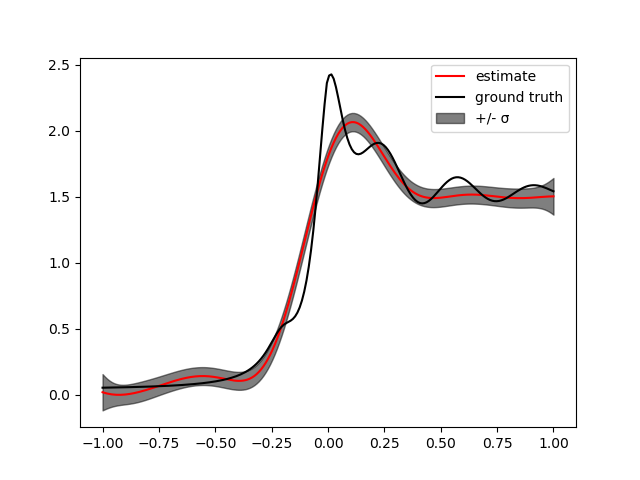

In [48]:
figure()
μ = m.predict_mean(torch.linspace(-1,1,200).unsqueeze(1)).detach().numpy().squeeze()
σ = np.sqrt(m.predict_var(torch.linspace(-1,1,200).unsqueeze(1)).detach().numpy().squeeze())
plot(torch.linspace(-1,1,200).numpy(), μ, color='r',label='estimate')
fill_between(torch.linspace(-1,1,200).numpy(), μ + σ, μ - σ,color='k',alpha=0.5,label='+/- σ')
plot(x[:200],y,color='k',label='ground truth')
legend()

<IPython.core.display.Javascript object>


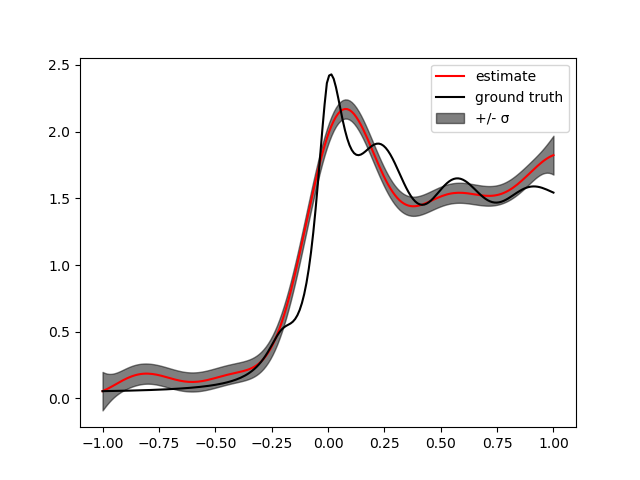

In [37]:
figure()
μ = m.predict_mean(torch.linspace(-1,1,200).unsqueeze(1)).detach().numpy().squeeze()
σ = np.sqrt(m.predict_var(torch.linspace(-1,1,200).unsqueeze(1)).detach().numpy().squeeze())
plot(torch.linspace(-1,1,200).numpy(), μ, color='r',label='estimate')
fill_between(torch.linspace(-1,1,200).numpy(), μ + σ, μ - σ,color='k',alpha=0.5,label='+/- σ')
plot(x[:200],y,color='k',label='ground truth')
legend()

<IPython.core.display.Javascript object>


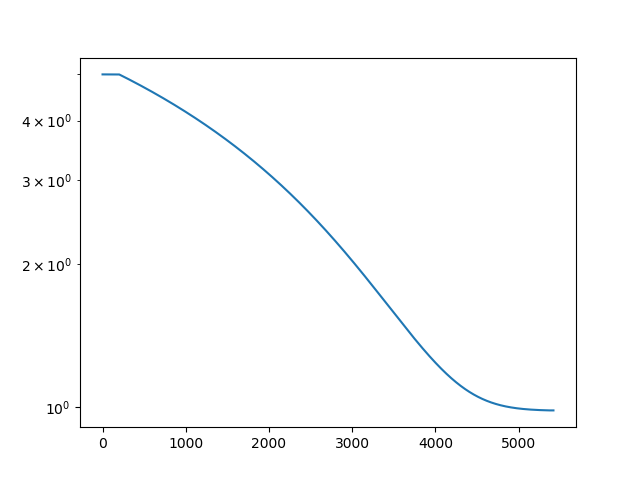

<IPython.core.display.Javascript object>


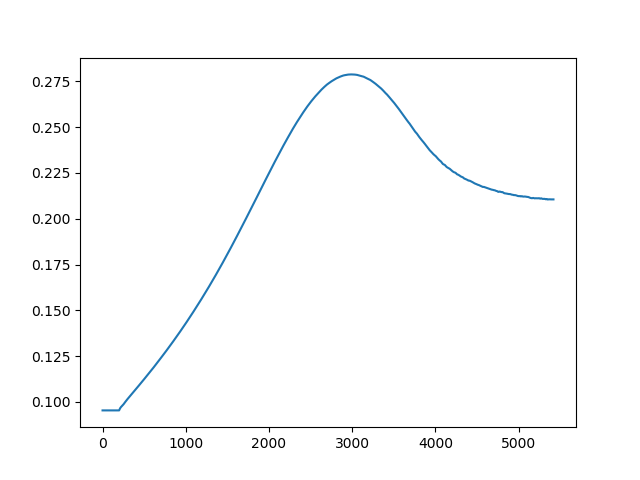

<IPython.core.display.Javascript object>


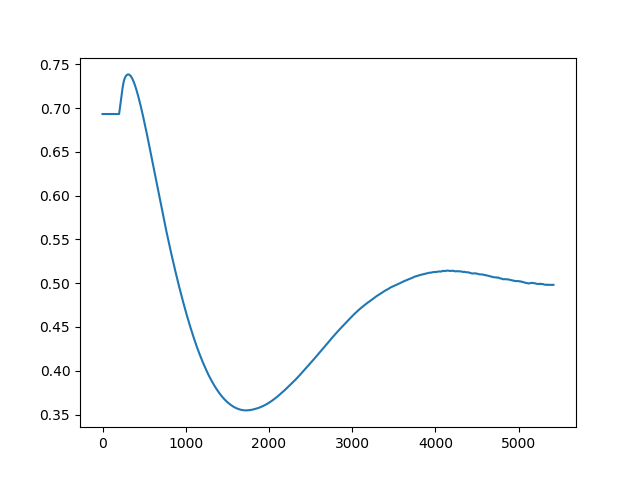

<IPython.core.display.Javascript object>


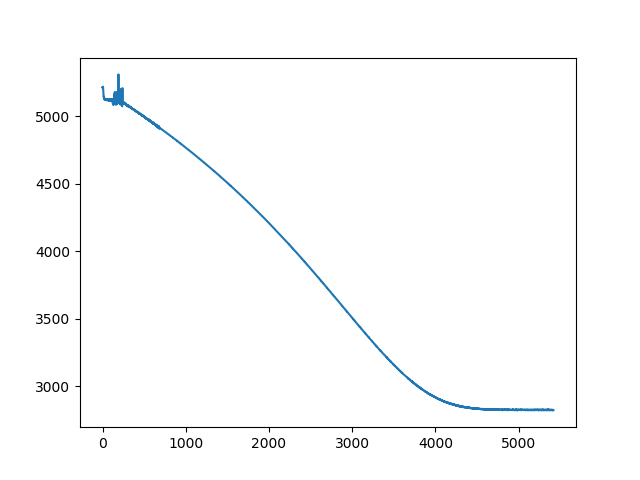

<IPython.core.display.Javascript object>


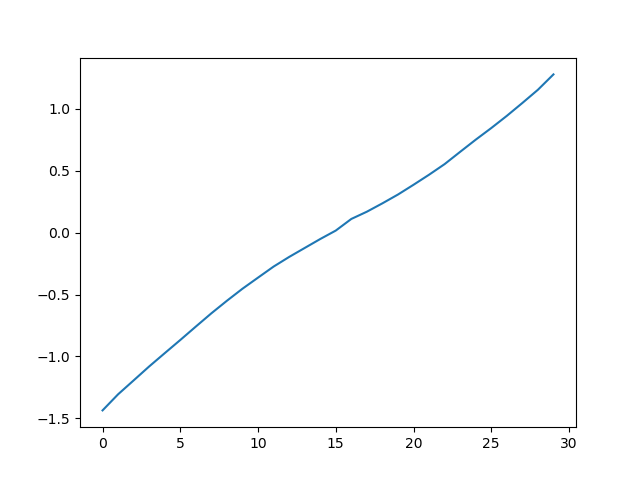

In [38]:
figure()
semilogy(Logger.val_dict['hyper_params.std_lik'])
figure()
plot(Logger.val_dict['stored_modules.K._lengthscale_storage'])
figure()
plot(Logger.val_dict['stored_modules.K._amplitude_storage'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u'].detach().numpy().squeeze()))

## Example 2a

1. 1D GPMM
2. Gaussian likelihood
3. MC evaluation of variational expectation, aka reparameterization gradients

In [72]:
X, yc, y = make_fake_herfd_weighted(100000, 100)

<IPython.core.display.Javascript object>


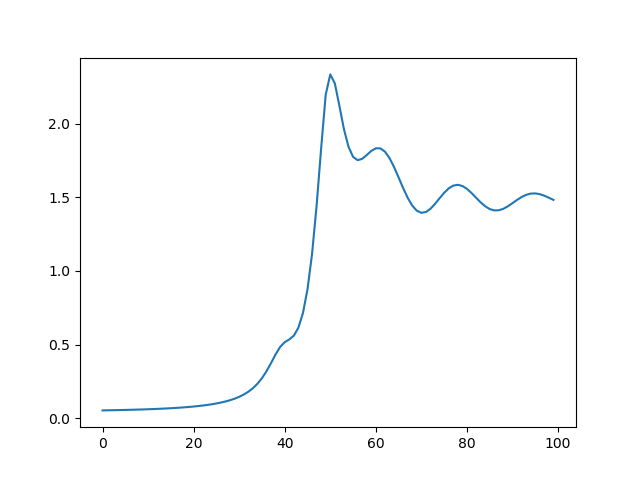

In [40]:
figure()
plot(y)

In [59]:
class VFE_1D_GPMM(torch.nn.Module):
    def __init__(self, U0, F0, Ntotal, Nmc=10, std_lik_init = 0.5, lenscale_init = 0.05,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        t = Vector('t')
        mprior = MeanSymbol('mprior')
        T0 = Matrix('T0')
        u0 = Vector('u0')
        f0 = Vector('f0')
        K0 = Kernel('K0')
        y = Vector('y')
        X = Matrix('X')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        Nmc = Constant(Nmc)
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl(K0, u0, mprior, T0, t, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        mf = weighted_mean(K0, u0, f0, mprior, T0, t, X, jitter)
        varf = weighted_var_fullspace_diag(K0, f0, X) - weighted_var_subspace_diag(K0, u0, f0, X, jitter) + \
                weighted_var_posterior_diag(K0, u0, f0, T0, X, jitter)
        
        ### Gaussian Likelihood in f-space ###
        ϵ = StdNormalSample(mf,Nmc)
        z = Sqrt(varf)*ϵ + mf
        ve_loss = gaussian_likelihood(y, z, std_lik, Ntotal)
#         ve_loss = analytic_gaussian_likelihood(y, mf, varf, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K0, u0, f0, mprior, T0, t, jitter)
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K0, f0) - var_subspace_diag(K0, u0, f0, jitter) + \
                var_posterior_diag(K0, u0, f0, T0, jitter)
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        #symbolic functions needed for natural gradient:
        xi_to_source = natural_to_source(t,T0,jitter)
        graph = expr2graph(Label(String("expr"), xi_to_source))
        self._xi_to_source = graph2ast(graph, compiled=True, debug=False)
        source_mean = Vector('source_mean')
        source_var = Matrix('source_var')
        source_to_xi = source_to_natural(source_mean, source_var, jitter)
        graph = expr2graph(Label(String("expr"), source_to_xi))
        self._source_to_xi = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f0': torch.nn.Parameter(torch.linspace(-1,1,F0,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]])),
                'mprior': ConstantMean(torch.tensor(0.))
                })
            #modules containing variational parameters go here:
            priorL = (self.stored_modules['K0'](self.hyper_params['u0'],self.hyper_params['u0']) + 
                  torch.eye(U0)*1e-4).cholesky()
            priorT = 0.5*torch.triangular_solve(torch.triangular_solve(torch.eye(U0),priorL,upper=False).solution,priorL,upper=False,transpose=True).solution
            self.variational_gaussian = MVNGaussianNatural(U0, dtype=self.dtype)
            self.variational_gaussian.custom_T_init(priorT)
    def kl_loss(self):
        t, T0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'T0': T0,
            't': t
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X):
        t, T0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            'T0': T0,
            't': t,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X):
        t, T0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            'T0': T0,
            't': t,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self):
        t, T0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'T0': T0,
            't': t,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self):
        t, T0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'T0': T0,
            't': t,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var_pred(**leaves)
        return result.var_pred
    def xi_to_source(self, xi):
        t, T0 = self.variational_gaussian.unpack()
        leaves = {
                'f': x,
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'T0': T0,
                't': t
            }
        m,S = self._xi_to_source(**leaves).expr
        return [m,S]
    def source_to_xi(self, m, S):
        leaves = {
                'f': x,
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'source_mean': m,
                'source_var': S
            }
        xi_unpacked = self._source_to_xi(**leaves).expr
        xi = self.variational_gaussian.pack(xi_unpacked)
        if torch.is_tensor(xi):
            return [xi]
        else:
            return list(xi)

In [64]:
m = VFE_1D_GPMM(50,100,100000);
# m.hyper_params['u'].requires_grad = False
# m.stored_modules['K']._lengthscale_storage.requires_grad = False
# m.stored_modules['K']._amplitude_storage.requires_grad = False
# m.stored_modules['m0'].value.requires_grad = False
# m.cuda()
hyper_optimizer = PatchAdam(chain(m.hyper_params.parameters(), m.stored_modules.parameters()),lr=1e-3)
optimizer = NaturalGradient(m.variational_gaussian.parameters(), lr=1)
schedule = LogSpaceScheduler(optimizer, -5, -1.5, 10)
bigbatcher = BigBatchScheduler(1000,10000,10,50)


initial = 5
epochs = 100
final = -5
# scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(torch.from_numpy(X.astype('float32')), torch.from_numpy(yc.astype('float32')))
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_modules.K0._lengthscale_storage': m._makepos,
                          'stored_modules.K0._amplitude_storage': m._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})
c = 0
while c < epochs:
    bsize = bigbatcher.step()
    print(bsize)
    d = DataLoader(dataset=data, shuffle=True, batch_size=int(bsize))
    for (xb,yb) in d:
#         xbc, ybc = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        hyper_optimizer.zero_grad()
        loss = m.loss(yb, xb)
        loss.backward()
        if c == initial:
            schedule.reset()
        schedule.step()
        optimizer.step(m.xi_to_source, m.source_to_xi)
        if c < initial or c > epochs + final:
            hyper_optimizer.step(null_step=True)
        else:
            hyper_optimizer.step(null_step=False)
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    print(Logger.report("epoch {:d}: ".format(c)))
    c += 1

Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/8406c4692df9e460.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/6d84f739a1f5c993.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/ae0665039077581c.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/bd51c1eabbaebb1b.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/78295a0b68c97a37.py
Module path:  /Users/fdfuller/SLAC National Accelerator Laboratory/Fuller Group - Documents/Code/Frank/torchgp/notebooks/reparam/.compiled/da3bc4f5ea3495a5.py
Module path:  /Users/fdfuller/SLAC National Ac

epoch 39: hyper_params.std_lik: 0.100174, stored_modules.K0._lengthscale_storage: 0.0893018, stored_modules.K0._amplitude_storage: 0.331374, loss: -86457.5, step_size: 0.0316228, 
1000
epoch 40: hyper_params.std_lik: 0.100186, stored_modules.K0._lengthscale_storage: 0.0881715, stored_modules.K0._amplitude_storage: 0.335123, loss: -86271.8, step_size: 0.0316228, 
1000
epoch 41: hyper_params.std_lik: 0.100221, stored_modules.K0._lengthscale_storage: 0.0891607, stored_modules.K0._amplitude_storage: 0.33204, loss: -88597.4, step_size: 0.0316228, 
1000
epoch 42: hyper_params.std_lik: 0.100229, stored_modules.K0._lengthscale_storage: 0.0892166, stored_modules.K0._amplitude_storage: 0.331613, loss: -90657.4, step_size: 0.0316228, 
1000
epoch 43: hyper_params.std_lik: 0.100183, stored_modules.K0._lengthscale_storage: 0.0900847, stored_modules.K0._amplitude_storage: 0.328963, loss: -88128.9, step_size: 0.0316228, 
1000
epoch 44: hyper_params.std_lik: 0.100183, stored_modules.K0._lengthscale_sto

KeyboardInterrupt: 

In [65]:
m.cpu()

VFE_1D_GPMM(
  (hyper_params): ParameterDict(
      (f0): Parameter containing: [torch.FloatTensor of size 100x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u0): Parameter containing: [torch.FloatTensor of size 50x1]
  )
  (stored_modules): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.0892]]), amplitude=0.338456928730011)
    (mprior): ConstantMean(value=0.9457371830940247)
  )
  (variational_gaussian): MVNGaussianNatural(
    (packed_params): ModuleDict(
      (t): WrappedVector()
      (T): UnconstrainedSymmetricMatrix()
    )
  )
)

<IPython.core.display.Javascript object>


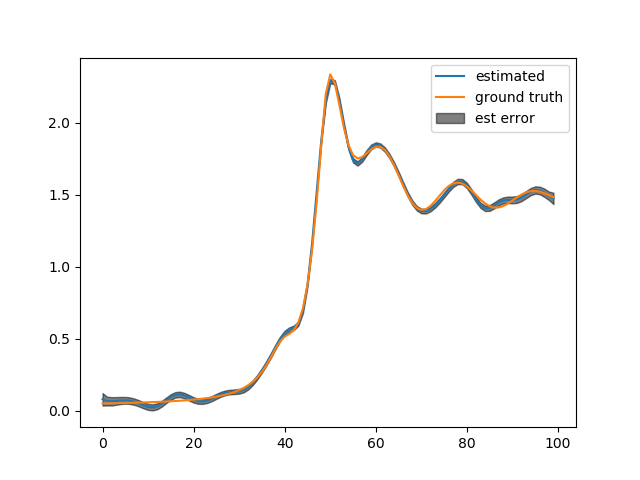

In [66]:
figure()
μ = m.predict_mean().detach().squeeze().numpy()
σ = m.predict_var().detach().sqrt().squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(100),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot(y,label='ground truth')
legend()

<IPython.core.display.Javascript object>


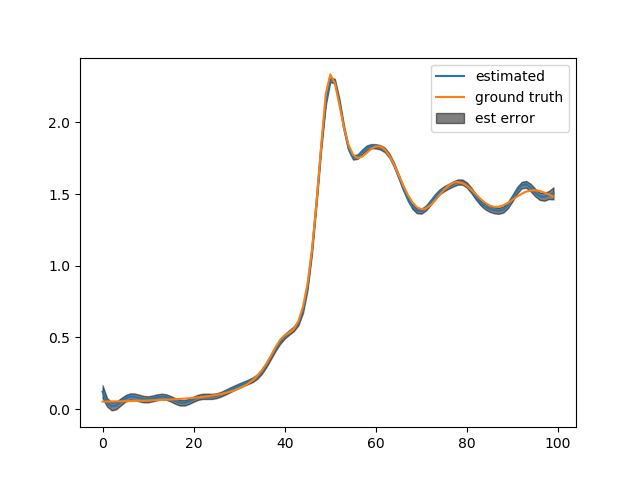

In [64]:
figure()
μ = m.predict_mean().detach().squeeze().numpy()
σ = m.predict_var().detach().sqrt().squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(100),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot(y,label='ground truth')
legend()

<IPython.core.display.Javascript object>


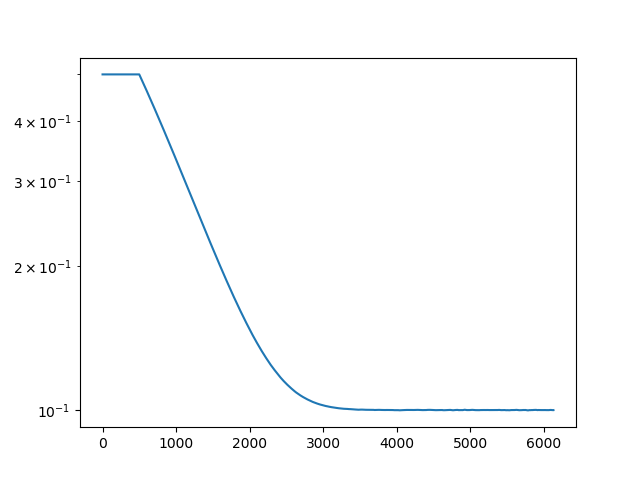

<IPython.core.display.Javascript object>


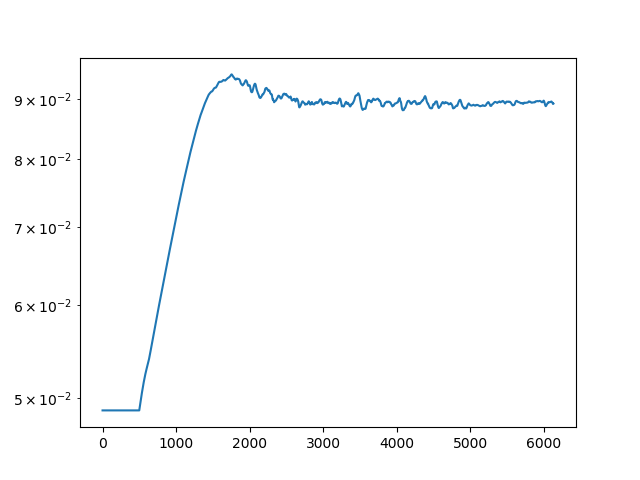

<IPython.core.display.Javascript object>


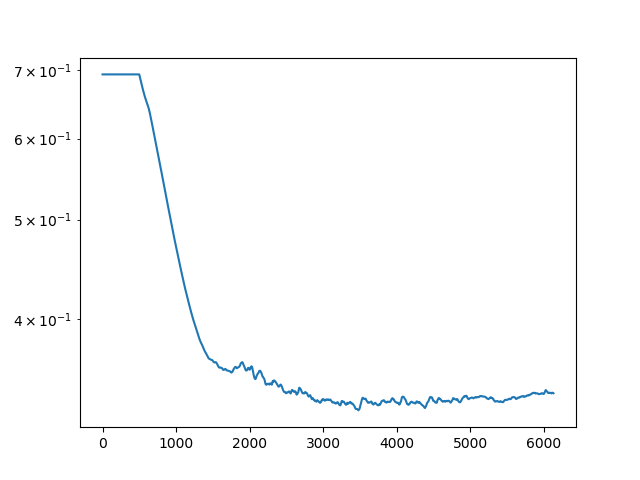

<IPython.core.display.Javascript object>


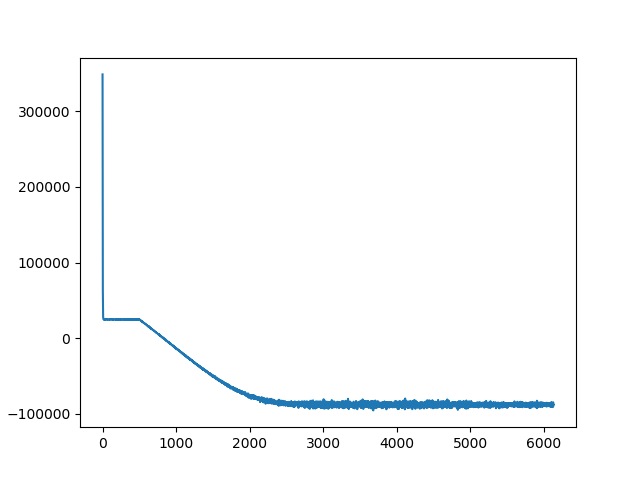

<IPython.core.display.Javascript object>


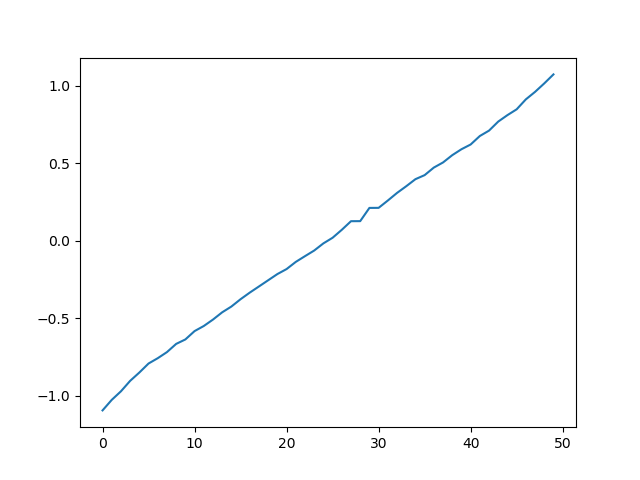

In [70]:
figure()
semilogy(Logger.val_dict['hyper_params.std_lik'])
figure()
semilogy(Logger.val_dict['stored_modules.K0._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_modules.K0._amplitude_storage'])
# figure()
# plot(Logger.val_dict['stored_modules.mprior.value'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u0'].detach().numpy().squeeze()))

## Example 3: GPMM with Poisson Noise & Poisson Likelihood

In [2]:
X,  yc, y = make_fake_herfd_weighted(100000, 100, noise_type='Poisson')

In [3]:
class VFE_1D_GPMM_Poisson(torch.nn.Module):
    def __init__(self, U0, F0, Ntotal, Nmc=10, max_root_rank = 100, std_lik_init = 0.5, lenscale_init = 0.15,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        t = Vector('t')
        mprior = MeanSymbol('mprior')
        T0 = Matrix('T0')
        u0 = Vector('u0')
        f0 = Vector('f0')
        K0 = Kernel('K0')
        y = Vector('y')
        X = Matrix('X')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        Nmc = Constant(Nmc)
        max_root_rank = Constant(max_root_rank)
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl(K0, u0, mprior, T0, t, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        mf = mean(K0, u0, f0, mprior, T0, t, jitter)
        varf = var_fullspace(K0, f0) - var_subspace(K0, u0, f0, jitter) + \
                var_posterior(K0, u0, f0, T0, jitter)
        varf_factorize = RRUL(varf, max_root_rank, jitter)
        varf_U = Select(Constant(0), varf_factorize)
        varf_L = Select(Constant(1), varf_factorize)
#         varf_L = CholeskyRoot(AddJitter(varf,jitter))
        
        ### Gaussian Likelihood in f-space ###
        ϵ = StdNormalSampleVarSize(varf_L,Select(Constant(0), Shape(X)))
#         ϵ = StdNormalSample(varf_L,Nmc)
        z = Softplus((varf_U @ (varf_L @ ϵ)) + mf)
#         z = Softplus((varf_L @ ϵ) + mf)
        wz = PartialSum(X * Transpose(z),Constant(1))
#         wz = X @ z
        ve_loss = poisson_likelihood(y, wz, Ntotal)
#         ve_loss = analytic_gaussian_likelihood(y, mf, varf, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean(K0, u0, f0, mprior, T0, t, jitter)
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = var_fullspace_diag(K0, f0) - var_subspace_diag(K0, u0, f0, jitter) + \
                var_posterior_diag(K0, u0, f0, T0, jitter)
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        #symbolic functions needed for natural gradient:
        xi_to_source = natural_to_source(t,T0,jitter)
        graph = expr2graph(Label(String("expr"), xi_to_source))
        self._xi_to_source = graph2ast(graph, compiled=True, debug=False)
        source_mean = Vector('source_mean')
        source_var = Matrix('source_var')
        source_to_xi = source_to_natural(source_mean, source_var, jitter)
        graph = expr2graph(Label(String("expr"), source_to_xi))
        self._source_to_xi = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f0': torch.nn.Parameter(torch.linspace(-1,1,F0,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_modules = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), amplitude=6.),
                'mprior': ConstantMean(torch.tensor(3.))
                })
            #modules containing variational parameters go here:
            priorL = (self.stored_modules['K0'](self.hyper_params['u0'],self.hyper_params['u0']) + 
                  torch.eye(U0)*1e-4).cholesky()
            priorT = 0.5*torch.triangular_solve(torch.triangular_solve(torch.eye(U0),priorL,upper=False).solution,priorL,upper=False,transpose=True).solution
            self.variational_gaussian = MVNGaussianNatural(U0, dtype=self.dtype)
#             self.variational_gaussian.custom_T_init(priorT)
    def kl_loss(self):
        t, T0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'T0': T0,
            't': t
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X):
        t, T0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            'T0': T0,
            't': t,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X):
        t, T0 = self.variational_gaussian.unpack()
        leaves = {
            'y': y,
            'X': X,
            **self.hyper_params,
            **self.stored_modules,
            'T0': T0,
            't': t,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self):
        t, T0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'T0': T0,
            't': t,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self):
        t, T0 = self.variational_gaussian.unpack()
        leaves = {
            **self.hyper_params,
            **self.stored_modules,
            'T0': T0,
            't': t,
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var_pred(**leaves)
        return result.var_pred
    def xi_to_source(self, xi):
        t, T0 = self.variational_gaussian.unpack()
        leaves = {
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'T0': T0,
                't': t
            }
        m,S = self._xi_to_source(**leaves).expr
        return [m,S]
    def source_to_xi(self, m, S):
        leaves = {
                **self.hyper_params,
                **self.stored_modules,
                'std_lik': self._makepos(self.hyper_params['std_lik']),
                'source_mean': m,
                'source_var': S
            }
        xi_unpacked = self._source_to_xi(**leaves).expr
        xi = self.variational_gaussian.pack(xi_unpacked)
        if torch.is_tensor(xi):
            return [xi]
        else:
            return list(xi)

In [4]:
m = VFE_1D_GPMM_Poisson(80,100,100000);
# m.hyper_params['u0'].requires_grad = False
# m.stored_modules['K']._lengthscale_storage.requires_grad = False
# m.stored_modules['K']._amplitude_storage.requires_grad = False
# m.stored_modules['m0'].value.requires_grad = False
m.cuda()
hyper_optimizer = PatchAdam(chain(m.hyper_params.parameters(), m.stored_modules.parameters()),lr=1e-3)
optimizer = ConstrainedNaturalGradient(m.variational_gaussian.parameters(), lr=0.01, norm_ratio=0.01)
# schedule = LogSpaceScheduler(optimizer, -7, -2.0, 5)
bigbatcher = BigBatchScheduler(10000,100000,10,50)


initial = 150
epochs = 150
final = -50
# scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(torch.from_numpy(X.astype('float32')), torch.from_numpy(yc.astype('float32')))
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_modules.K0._lengthscale_storage': m._makepos,
                          'stored_modules.K0._amplitude_storage': m._makepos,
                          'stored_modules.mprior.value': lambda x: x},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

c = 0
means = []
stds = []

Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/40c0c055700e5b95.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/d2c34c149a7768a1.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/5ab5faf59683dd3a.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/169e00bbec6886b2.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/15fee7684f656e85.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/81be9d3258525c0d.py
Module path:  /home/fdfuller/work/torchgp/notebooks/reparam/.compiled/e0d7540158c28965.py


In [5]:
m.cuda()
while c < epochs:
    bsize = bigbatcher.step()
    print(bsize)
    d = DataLoader(dataset=data, shuffle=True, batch_size=bsize)
    for (xb,yb) in d:
        xbc, ybc = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        hyper_optimizer.zero_grad()
        loss = m.loss(ybc, xbc)
        loss.backward()
#         schedule.step()
#         print(optimizer.param_groups[0]['lr'])
        lr = optimizer.step(m.xi_to_source, m.source_to_xi, m.variational_gaussian.pack, m.variational_gaussian.unpack)
        if c < initial or c > epochs + final:
            hyper_optimizer.step(null_step=True)
        else:
            hyper_optimizer.step(null_step=False)
        Logger(extra_vals=[float(loss), float(lr)])
    print(Logger.report("epoch {:d}: ".format(c)))
    with torch.no_grad():
        means.append(m.predict_mean().detach().squeeze())
        stds.append(m.predict_var().detach().sqrt().squeeze())
    c += 1

10000
epoch 0: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 531477, step_size: 2.88204e-06, 
10000
epoch 1: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 514699, step_size: 3.14375e-06, 
10000
epoch 2: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 506296, step_size: 3.45031e-06, 
10000
epoch 3: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 480719, step_size: 3.78526e-06, 
10000
epoch 4: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 461955, step_size: 4.16297e-06, 


epoch 41: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 193551, step_size: 0.000162389, 
10000
epoch 42: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 193363, step_size: 0.000179664, 
10000
epoch 43: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 193003, step_size: 0.000198892, 
10000
epoch 44: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 192118, step_size: 0.000220079, 
10000
epoch 45: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 192772, step_size: 0.000243549, 
1

epoch 82: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 190070, step_size: 0.00222989, 
20000
epoch 83: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 190831, step_size: 0.00237136, 
20000
epoch 84: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 190094, step_size: 0.0025137, 
20000
epoch 85: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 190443, step_size: 0.0026887, 
20000
epoch 86: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.15, stored_modules.K0._amplitude_storage: 6, stored_modules.mprior.value: 3, loss: 191130, step_size: 0.00286297, 
20000
ep

RuntimeError: cholesky_cuda: U(68,68) is zero, singular U.

In [6]:
m.cpu()

VFE_1D_GPMM_Poisson(
  (hyper_params): ParameterDict(
      (f0): Parameter containing: [torch.FloatTensor of size 100x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u0): Parameter containing: [torch.FloatTensor of size 80x1]
  )
  (stored_modules): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.1500]]), amplitude=6.0)
    (mprior): ConstantMean(value=3.0)
  )
  (variational_gaussian): MVNGaussianNatural(
    (packed_params): ModuleDict(
      (t): WrappedVector()
      (T): UnconstrainedSymmetricMatrix()
    )
  )
)

In [7]:
m.stored_modules['K0'].amplitude

tensor(6., grad_fn=<SoftplusBackward>)

In [8]:
t, T = m.variational_gaussian.unpack()

In [9]:
E,Q = torch.symeig(T)

In [12]:
E.min()

tensor(-0.7379, grad_fn=<MinBackward1>)

<IPython.core.display.Javascript object>


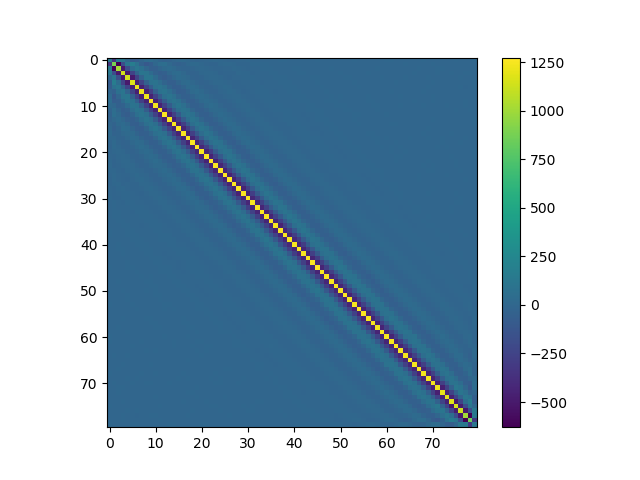

In [11]:
figure()
imshow(T.detach())
colorbar()

<IPython.core.display.Javascript object>


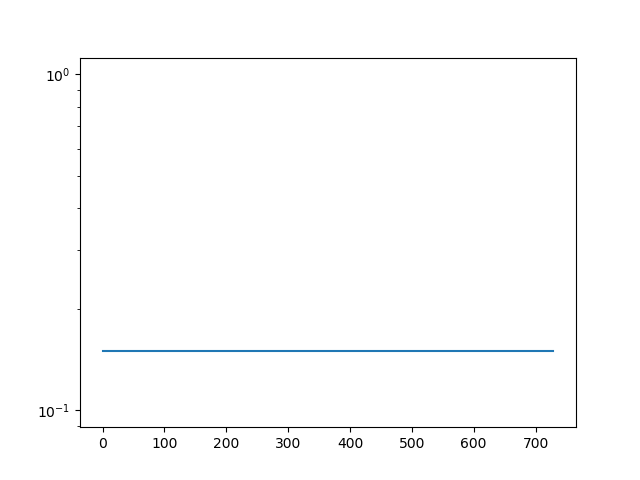

<IPython.core.display.Javascript object>


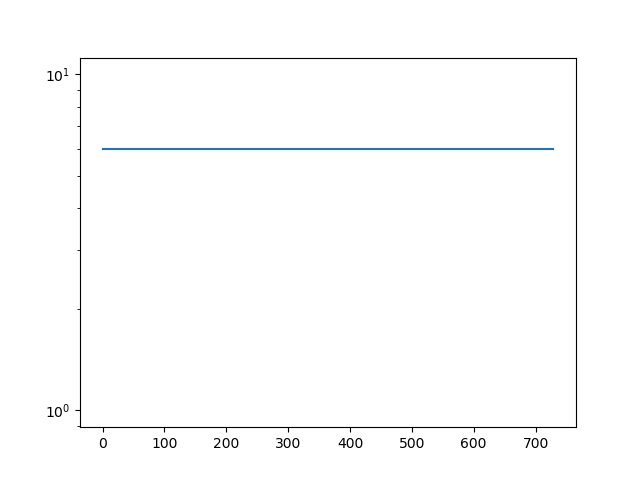

<IPython.core.display.Javascript object>


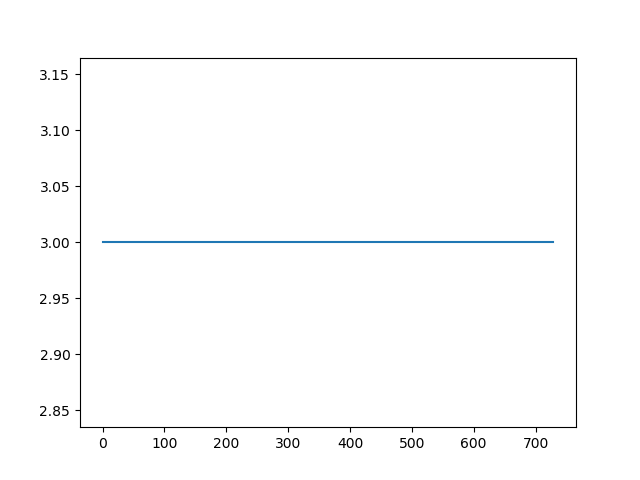

<IPython.core.display.Javascript object>


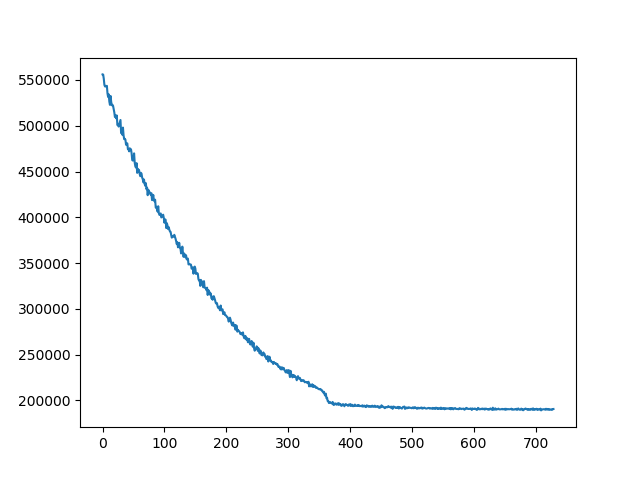

<IPython.core.display.Javascript object>


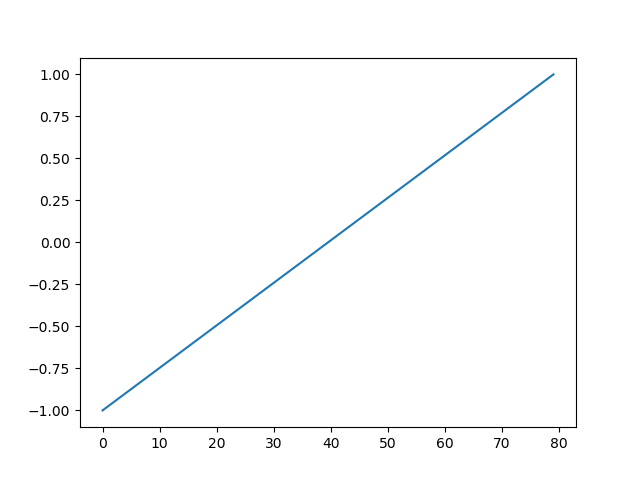

In [13]:
figure()
semilogy(Logger.val_dict['stored_modules.K0._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_modules.K0._amplitude_storage'])
figure()
plot(Logger.val_dict['stored_modules.mprior.value'])
figure()
plot(Logger.val_dict['loss'])
figure()
plot(np.sort(m.hyper_params['u0'].detach().numpy().squeeze()))

<IPython.core.display.Javascript object>


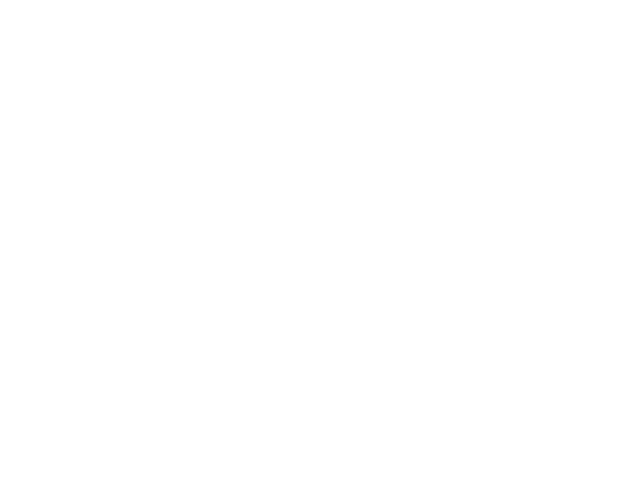

RuntimeError: cholesky_cpu: U(68,68) is zero, singular U.

In [14]:
figure()
μ = m.predict_mean().detach().squeeze()
σ = m.predict_var().detach().sqrt().squeeze()
plot(torch.nn.functional.softplus(μ).numpy(), label='estimated')
fill_between(np.arange(100),torch.nn.functional.softplus(μ+σ).numpy(),torch.nn.functional.softplus(μ-σ).numpy(),color='k',alpha=0.5,label='est error')
plot(y*np.sqrt(10),label='ground truth')
legend()
# savefig('100k-shots-nat-grad-nat-param-HERFD.png')

In [15]:
ms = torch.cat([x.unsqueeze(1).cpu() for x in means],dim=1).numpy()
ss = torch.cat([x.unsqueeze(1).cpu() for x in stds],dim=1).numpy()

<IPython.core.display.Javascript object>


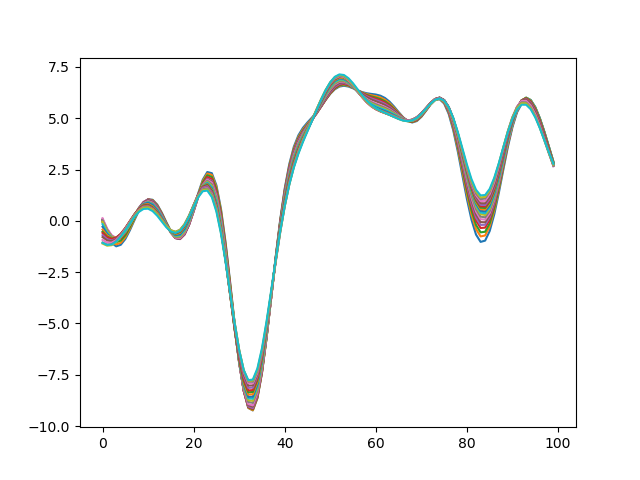

In [16]:
figure()
plot(ms[:,-20:])

<IPython.core.display.Javascript object>


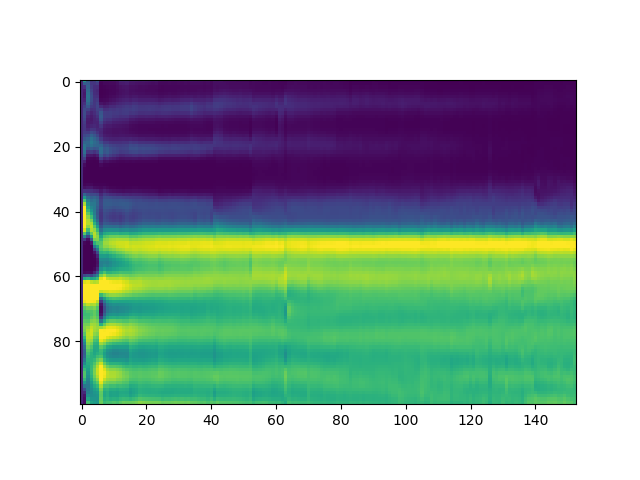

In [155]:
figure()
vmin, vmax = np.percentile(ms.ravel(),[1,99])
imshow(ms[:,:],vmin=vmin, vmax=vmax,aspect=1.0)
# colorbar()
# savefig('100k-poisson-HERFD-natgrad-natparam-mean-evolution.png')

<IPython.core.display.Javascript object>


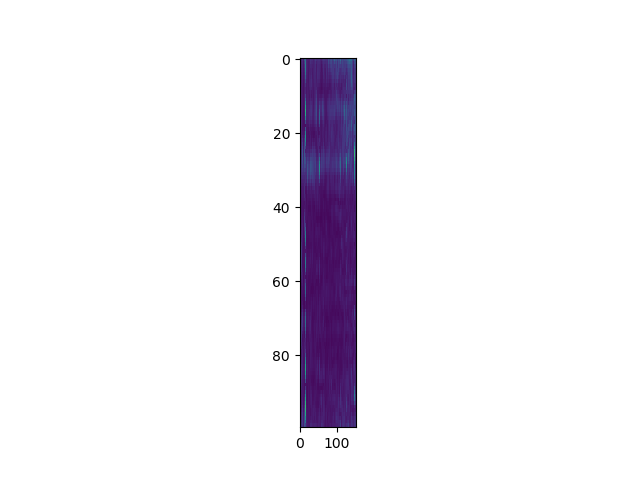

In [156]:
figure()
vmin, vmax = np.percentile(ms.ravel(),[1,99])
imshow(ss[:,:],vmin=vmin, vmax=vmax,aspect=10.0)
# colorbar()
# savefig('100k-poisson-HERFD-natgrad-natparam-std-evolution.png')

In [89]:
# m = VFE_1D_GPMM_Poisson(30,100,30000, Nmc=10);
# m.hyper_params['u'].requires_grad = False
# m.stored_modules['K0']._lengthscale_storage.requires_grad = False
# m.stored_modules['K0']._amplitude_storage.requires_grad = False
# m.stored_modules['mprior'].value.requires_grad = False
# m.cuda()
# hyper_optimizer = torch.optim.Adam(chain(m.hyper_params.parameters(), m.stored_modules.parameters()),lr=1e-2)
# optimizer = NaturalGradient(m.variational_gaussian.parameters(), lr=1)
# optimizer2 = torch.optim.Adam(m.variational_gaussian.parameters(), lr=1e-2)
# schedule = LogSpaceScheduler(optimizer, -5, -2, 100)
# bigbatcher = BigBatchScheduler(100000,100000,10,5)


epochs = 300
# scheduler = StepLR(optimizer,50,gamma=0.95)

# data = TensorDataset(torch.from_numpy(X.astype('float32')), torch.from_numpy(yc.astype('float32')))
# Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
#                           'stored_modules.K0._lengthscale_storage': m._makepos,
#                           'stored_modules.K0._amplitude_storage': m._makepos,
#                           'stored_modules.mprior.value': lambda x: x},
#                      extra_keys={'loss': lambda x: x,
#                                 'step_size': lambda x: x})

for i in range(epochs):
#     bsize = bigbatcher.step()
#     print(bsize)
    d = DataLoader(dataset=data, shuffle=True, batch_size=30000)
    for (xb,yb) in d:
#         xbc, ybc = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
#         optimizer2.zero_grad()
        hyper_optimizer.zero_grad()
        loss = m.loss(yb, xb)
        loss.backward()
        hyper_optimizer.step()
        schedule.step()
        optimizer.step(m.xi_to_source, m.source_to_xi)
#         optimizer2.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    print(Logger.report("epoch {:d}: ".format(i)))
        

epoch 0: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0481469, stored_modules.K0._amplitude_storage: 1.46642, stored_modules.mprior.value: 2.25916, loss: 63629, step_size: 1e-05, 
epoch 1: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0482217, stored_modules.K0._amplitude_storage: 1.46743, stored_modules.mprior.value: 2.27202, loss: 60652.8, step_size: 1.07227e-05, 
epoch 2: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0482909, stored_modules.K0._amplitude_storage: 1.46851, stored_modules.mprior.value: 2.28452, loss: 63098.1, step_size: 1.14976e-05, 
epoch 3: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.048348, stored_modules.K0._amplitude_storage: 1.46971, stored_modules.mprior.value: 2.297, loss: 65120.2, step_size: 1.23285e-05, 
epoch 4: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0483502, stored_modules.K0._amplitude_storage: 1.47081, stored_modules.mprior.value: 

epoch 39: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0475938, stored_modules.K0._amplitude_storage: 1.49227, stored_modules.mprior.value: 2.55199, loss: 58724.3, step_size: 0.000151991, 
epoch 40: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0476179, stored_modules.K0._amplitude_storage: 1.49301, stored_modules.mprior.value: 2.55751, loss: 58875.5, step_size: 0.000162975, 
epoch 41: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0476486, stored_modules.K0._amplitude_storage: 1.49375, stored_modules.mprior.value: 2.5627, loss: 59152.4, step_size: 0.000174753, 
epoch 42: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0476453, stored_modules.K0._amplitude_storage: 1.49453, stored_modules.mprior.value: 2.56721, loss: 60187.4, step_size: 0.000187382, 
epoch 43: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0476242, stored_modules.K0._amplitude_storage: 1.49533, stored_modules

epoch 78: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0471934, stored_modules.K0._amplitude_storage: 1.51021, stored_modules.mprior.value: 2.65882, loss: 57578.6, step_size: 0.00231013, 
epoch 79: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0471971, stored_modules.K0._amplitude_storage: 1.51011, stored_modules.mprior.value: 2.65999, loss: 57828.2, step_size: 0.00247708, 
epoch 80: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0472, stored_modules.K0._amplitude_storage: 1.50996, stored_modules.mprior.value: 2.6611, loss: 57803.4, step_size: 0.00265609, 
epoch 81: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0472019, stored_modules.K0._amplitude_storage: 1.50986, stored_modules.mprior.value: 2.66196, loss: 57760.5, step_size: 0.00284804, 
epoch 82: hyper_params.std_lik: 0.5, stored_modules.K0._lengthscale_storage: 0.0472044, stored_modules.K0._amplitude_storage: 1.50973, stored_modules.mprior

RuntimeError: cholesky_cpu: U(4,4) is zero, singular U.